<div style="border: 2px solid #575757; padding: 10px; border-radius: 5px; background-color: #e1e1e1; color: black; text-align: center;">
  <h1 style="margin: 0;">Balance of Electricity / H<sub>2</sub> / Heat flow</h1>
</div>

<div style="border: 2px solid #FFA500; padding: 10px; border-radius: 5px; background-color: #FFFACD; color: black; text-align: center;">
  <h2 style="margin: 0;">Libraries importation</h2>
</div>

**Import required libraries:**

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import plotly.graph_objects as go
import dash
from dash import dcc, html, Input, Output, State
import json
import joblib
from tqdm.notebook import tqdm

<div style="border: 2px solid rgba(0, 158, 115, 1); padding: 10px; border-radius: 5px; background-color: rgba(0, 158, 115, 0.3); color: black; text-align: center;">
  <h2 style="margin: 0;">Electricity data importation</h2>
</div>

**Load and tranform the data:**

**Optional if you already have the *electricity_data.pkl* file**

- Creates a dictionary of DataFrames for the variables, indexed by scenario
- Take the absolute value for conventionnally negative variables (*Pdem*, *Php*, *Ppump*, *Ppemel*, *Pcomp*)
- Split alternative sign variables (*Pbat*, *Pgrid*) in two with only positive values and zeroes, for better clarity and code handling:
  - *Pbat* -> *PbatC* (charging) and *PbatD* (discharging)
  - *Pgrid* -> *PgridG* (giving to grid) and *PgridF* (feeding from grid)

**By default, *elec_variables.xlsx* is used.** 

This *elec_variables.xlsx* file is the result of relevant data extraction for electricity flows across scenarios, from the original .csv files.

In [15]:
# File path
file_path = "OM_extracted_outputs/elec_variables.xlsx"

# Sheet names to load
sheet_names = ["Psup", "Pchp", "Pwind", "Ppv", "Pdem", "electricity_load", "Php", "Ppump", "Pbat", "Ppemel", "Pcom", "Pgrid"]

# Load Excel file
xls = pd.ExcelFile(file_path)

# Load sheets with progress bar
print("📥 Loading sheets...")
data = {}
for sheet in tqdm(sheet_names, desc="Loading sheets"):
    data[sheet] = pd.read_excel(xls, sheet_name=sheet)

# Extract scenario names (columns starting with 'SIM')
scenarios = [col for col in data["Ppemel"].columns if col.startswith('SIM')]

# Prepare dictionary to hold data per scenario
electricity_data = {}

# Process scenarios with progress bar
print("🔄 Processing scenarios...")
for scenario in tqdm(scenarios, desc="Processing electricity scenarios"):
    scenario_df_list = []

    for var, df in data.items():
        if scenario in df.columns:
            temp_df = df[["time", scenario]].rename(columns={scenario: var})

            # For specific sheets, take absolute value
            if var in ["Pdem", "Php", "Ppump", "Ppemel", "Pcom"]:
                temp_df[var] = temp_df[var].abs()
            scenario_df_list.append(temp_df)

    # Merge all dataframes on time
    merged_df = scenario_df_list[0]
    for temp_df in scenario_df_list[1:]:
        merged_df = merged_df.merge(temp_df, on="time", how="outer")

    # Transform Pbat columns
    if "Pbat" in data:
        merged_df["PbatC"] = merged_df["Pbat"].apply(lambda x: max(x, 0))
        merged_df["PbatD"] = merged_df["Pbat"].apply(lambda x: abs(x) if x < 0 else 0)

    # Transform Pgrid columns
    if "Pgrid" in data:
        merged_df["PgridG"] = merged_df["Pgrid"].apply(lambda x: abs(x) if x < 0 else 0)
        merged_df["PgridF"] = merged_df["Pgrid"].apply(lambda x: max(x, 0))

    # Clean scenario key
    cleaned_scenario = scenario.replace(".csv", "")

    # Store dataframe indexed by time
    electricity_data[cleaned_scenario] = merged_df.set_index("time")

# Save dictionary to disk
os.makedirs("pickles", exist_ok=True)
joblib.dump(electricity_data, "pickles/electricity_data.pkl")
print("✅ Electricity data saved to pickles/electricity_data.pkl")


📥 Loading sheets...


Loading sheets:   0%|          | 0/12 [00:00<?, ?it/s]

🔄 Processing scenarios...


Processing electricity scenarios:   0%|          | 0/28 [00:00<?, ?it/s]

✅ Electricity data saved to pickles/electricity_data.pkl


**Verify the data structure (optional):**

In [ ]:
display(electricity_data)

<div style="border: 2px solid rgba(0, 158, 115, 1); padding: 10px; border-radius: 5px; background-color: rgba(0, 158, 115, 0.3); color: black; text-align: center;">
  <h2 style="margin: 0;">Processing Electricity scenarios</h2>
</div>

**Generate Dataframes for the different steps of flow calculations:**

**Optional if you already have the *all_elec_results.pkl* file and just want to generate Sankey diagrams**

<div style="padding: 5px; background-color: #FFFACD; color: black; text-align: center;">
  <h0 style="margin: 0;">The errors prompts are just related to computation of relative differences between flows equal to 0</h0>
</div>

In [3]:
########## INIT COMPUTATIONS STORAGE PER SCENARIO ##########
########## for future manipulation and display ##########

# Load the saved data using joblib
electricity_data = joblib.load("pickles/electricity_data.pkl")

# All summed flows from component to component
all_elec_results = []

# All synthesis values for Elec production (for later computations regarding CHP)
all_elec_synthesis = []

# All values for elec overproduction
all_elec_overprod = []

# All summed values of variables at each step of allocation
all_steps = []

# All verification computations
all_verif = []

# All verification computations
all_deltas = []
all_Sdeltas = []

for scenario, df in electricity_data.items():

    ########## INIT FOR ALLOCATION ##########
    print(scenario)
    # Extract individual series for the scenario
    Psup, Pchp, Pwind, Ppv = df["Psup"], df["Pchp"], df["Pwind"], df["Ppv"]
    Pdem, Pload, Php, Ppump = df["Pdem"],  df["electricity_load"], df["Php"], df["Ppump"]
    PbatC, PbatD = df["PbatC"], df["PbatD"]
    Ppemel, Pcom = df["Ppemel"], df["Pcom"]
    PgridG, PgridF = df["PgridG"], df["PgridF"]

    # Initialize computation of electricity flows with proportional allocation
    flows = {}
    verif = {}

    # Available electricity supply and demand
    all_supply = {"Pchp": Pchp, "Pwind": Pwind, "Ppv": Ppv, "Pbat": PbatD, "Pgrid": PgridF}
    all_demand = {"Pload": Pload, "Php": Php, "Ppump": Ppump, "Pbat": PbatC, "Ppemel": Ppemel, "Pcom": Pcom, "Pgrid": PgridG}

    total_all_supply =  np.sum(list(all_supply.values()), axis=0)
    total_all_demand =  np.sum(list(all_demand.values()), axis=0)

    remaining_all_supply = {k: v.copy() for k, v in all_supply.items()}
    remaining_all_demand = {k: v.copy() for k, v in all_demand.items()}

    # Ratios of electricity supply and demand
    all_supply_ratios = {k: (all_supply[k] / total_all_supply).replace(np.nan, 0) for k in all_supply.keys()}
    all_demand_ratios = {k: (all_demand[k] / total_all_demand).replace(np.nan, 0) for k in all_demand.keys()}

    ########## DIRECT ALLOCATION ##########

    for source in all_supply.keys():
        for sink in all_demand.keys():
            flows[f"{source}->{sink}"] = all_supply_ratios[source] * all_demand_ratios[sink] * total_all_demand
            remaining_all_supply[source] -= flows[f"{source}->{sink}"]
            remaining_all_demand[sink] -= flows[f"{source}->{sink}"]

    ########## RESULTS & VERIF STORAGE ##########

    # Store flow results for each scenario + division by 1000 to convert Wh in kWh
    scenario_results = {col: np.sum(data) / 1000 for col, data in flows.items()}
    scenario_results["Scenario"] = scenario
    scenario_results_df = pd.DataFrame([scenario_results])
    all_elec_results = pd.concat([pd.DataFrame(all_elec_results), scenario_results_df], ignore_index=True)

    column_order = ["Scenario"] + [col for col in all_elec_results.columns if col != "Scenario"]
    all_elec_results = all_elec_results[column_order]

    # Store synthesis of Elec production for each scenario
    elec_synthesis_df = pd.DataFrame({
        'Scenario': scenario,
        'Ppv (kWh)': Ppv.sum() / 1000,
        'Ppv (MJ)': 3.6 * Ppv.sum() / 1000,
        'Pwind (kWh)': Pwind.sum() / 1000,
        'Pwind (MJ)': 3.6 * Pwind.sum() / 1000,
        'Pchp (kWh)': Pchp.sum() / 1000,
        'Pchp (MJ)': 3.6 * Pchp.sum() / 1000,
        'Pload (kWh)': Pload.sum() / 1000,
        'Pload (MJ)': 3.6 * Pload.sum() / 1000,
        'Php (kWh)': Php.sum() / 1000,
        'Php (MJ)': 3.6 * Php.sum() / 1000,
        'Ppemel (kWh)': Ppemel.sum() / 1000,
        'Ppemel (MJ)': 3.6 * Ppemel.sum() / 1000,
        'Pcom (kWh)': Pcom.sum() / 1000,
        'Pcom (MJ)': 3.6 * Pcom.sum() / 1000,
        'PbatD (kWh)': PbatD.sum() / 1000,
        'PbatD (MJ)': 3.6 * PbatD.sum() / 1000,
    }, index=[scenario])
    all_elec_synthesis = pd.concat([pd.DataFrame(all_elec_synthesis), elec_synthesis_df], ignore_index=True)

    # Store synthesis of elec overproduction for each scenario
    elec_overprod_df = pd.DataFrame({
        'Scenario': scenario,
        'PV overproduction (%)': 100 * (flows[f'Ppv->Pgrid'].sum() / Ppv.sum()),
        'WT overproduction (%)': 100 * (flows[f'Pwind->Pgrid'].sum() / Pwind.sum()),
        'CHP overproduction (%)': 100 * (flows[f'Pchp->Pgrid'].sum() / Pchp.sum()),
    }, index=[scenario])
    all_elec_overprod = pd.concat([pd.DataFrame(all_elec_overprod), elec_overprod_df], ignore_index=True)

    # Store remaining supply and demand at each step in terms of sums for each scenario + division by 1000 to convert Wh in kWh
    remaining_supdem_df = pd.DataFrame({
        'Scenario': scenario,
        'Psup': Psup.sum() / 1000,
        'Psup -Pdem': sum(Psup - Pdem) / 1000,
        'Psup -Pdem -PbatC': sum(Psup - Pdem - PbatC) / 1000,
        'Psup -Pdem -PbatC -Ppemel -Pcom': sum(Psup - Pdem - PbatC - Ppemel - Pcom) / 1000,
        'Psup -Pdem -PbatC -Ppemel -Pcom -PgridG': sum(Psup - Pdem - PbatC - Ppemel - Pcom - PgridG) / 1000,
        'Psup -Pdem -PbatC -Ppemel -Pcom -PgridG +PbatD +PgridF': sum(Psup - Pdem - PbatC - Ppemel - Pcom - PgridG + PbatD + PgridF) / 1000,
        'Pchp': Pchp.sum() / 1000, 'Pchp remaining': remaining_all_supply['Pchp'].sum() / 1000,
        'Pwind': Pwind.sum() / 1000, 'Pwind remaining': remaining_all_supply['Pwind'].sum() / 1000,
        'Ppv': Ppv.sum() / 1000, 'Ppv remaining': remaining_all_supply['Ppv'].sum() / 1000,
        'Pdem': Pdem.sum() / 1000,
        'Pdem -Psup': np.maximum(0, Pdem - Psup).sum() / 1000,
        'Pdem -Psup -PbatD -PgridF': np.maximum(0, Pdem - Psup - PbatD - PgridF).sum() / 1000,
        'Pload': Pload.sum() / 1000, 'Pload remaining': remaining_all_demand['Pload'].sum() / 1000,
        'Php': Php.sum() / 1000, 'Php remaining': remaining_all_demand['Php'].sum() / 1000,
        'Ppump': Ppump.sum() / 1000, 'Ppump remaining': remaining_all_demand['Ppump'].sum() / 1000,
        'PbatC': PbatC.sum() / 1000, 'PbatC remaining': remaining_all_demand['Pbat'].sum() / 1000,
        'Ppemel': Ppemel.sum() / 1000, 'Ppemel remaining':  remaining_all_demand['Ppemel'].sum() / 1000,
        'Pcom': Pcom.sum() / 1000, 'Pcom remaining':  remaining_all_demand['Pcom'].sum() / 1000,
        'PgridG': PgridG.sum() / 1000, 'PgridG remaining': remaining_all_supply['Pgrid'].sum() / 1000,
        'PbatD': PbatD.sum() / 1000, 'PbatD remaining': remaining_all_supply['Pbat'].sum() / 1000,
        'PgridF': PgridF.sum() / 1000, 'PgridF remaining': remaining_all_supply['Pgrid'].sum() / 1000,
    }, index=[scenario])
    all_steps = pd.concat([pd.DataFrame(all_steps), remaining_supdem_df], ignore_index=True)

    # Verification calculations
    Psup_verif = sum(flows[f'{source}->{sink}'] for source in ['Pchp', 'Pwind', 'Ppv'] for sink in ['Pload', 'Php', 'Ppump', 'Pbat', 'Ppemel', 'Pcom', 'Pgrid'] if f'{source}->{sink}' in flows)
    Pchp_verif = sum(flows[f'Pchp->{sink}'] for sink in ['Pload', 'Php', 'Ppump', 'Pbat', 'Ppemel', 'Pcom', 'Pgrid'] if f'Pchp->{sink}' in flows)
    Pwind_verif = sum(flows[f'Pwind->{sink}'] for sink in ['Pload', 'Php', 'Ppump', 'Pbat', 'Ppemel', 'Pcom', 'Pgrid'] if f'Pwind->{sink}' in flows)
    Ppv_verif = sum(flows[f'Ppv->{sink}'] for sink in ['Pload', 'Php', 'Ppump', 'Pbat', 'Ppemel', 'Pcom', 'Pgrid'] if f'Ppv->{sink}' in flows)
    Pdem_verif = sum(flows[f'{source}->Pload'] for source in ['Pchp', 'Pwind', 'Ppv', 'Pbat', 'Pgrid'] if f'{source}->Pload' in flows) + \
                 sum(flows[f'{source}->Php'] for source in ['Pchp', 'Pwind', 'Ppv', 'Pbat', 'Pgrid'] if f'{source}->Php' in flows) + \
                 sum(flows[f'{source}->Ppump'] for source in ['Pchp', 'Pwind', 'Ppv', 'Pbat', 'Pgrid'] if f'{source}->Ppump' in flows)
    Pload_verif = sum(flows[f'{source}->Pload'] for source in ['Pchp', 'Pwind', 'Ppv', 'Pbat', 'Pgrid'] if f'{source}->Pload' in flows)
    Php_verif = sum(flows[f'{source}->Php'] for source in ['Pchp', 'Pwind', 'Ppv', 'Pbat', 'Pgrid'] if f'{source}->Php' in flows)
    Ppump_verif = sum(flows[f'{source}->Ppump'] for source in ['Pchp', 'Pwind', 'Ppv', 'Pbat', 'Pgrid'] if f'{source}->Ppump' in flows)
    PbatC_verif = sum(flows[f'{source}->Pbat'] for source in ['Pchp', 'Pwind', 'Ppv', 'Pbat', 'Pgrid'] if f'{source}->Pbat' in flows)
    Ppemel_verif = sum(flows[f'{source}->Ppemel'] for source in ['Pchp', 'Pwind', 'Ppv', 'Pbat', 'Pgrid'] if f'{source}->Ppemel' in flows)
    Pcom_verif = sum(flows[f'{source}->Pcom'] for source in ['Pchp', 'Pwind', 'Ppv', 'Pbat', 'Pgrid'] if f'{source}->Pcom' in flows)
    PgridG_verif = sum(flows[f'{source}->Pgrid'] for source in ['Pchp', 'Pwind', 'Ppv', 'Pbat', 'Pgrid'] if f'{source}->Pgrid' in flows)
    PbatD_verif = sum(flows[f'Pbat->{sink}'] for sink in ['Pload', 'Php', 'Ppump', 'Pbat', 'Ppemel', 'Pcom', 'Pgrid'] if f'Pbat->{sink}' in flows)
    PgridF_verif = sum(flows[f'Pgrid->{sink}'] for sink in ['Pload', 'Php', 'Ppump', 'Pbat', 'Ppemel', 'Pcom', 'Pgrid'] if f'Pgrid->{sink}' in flows)

    # Store verifications compared to original in terms of sums for each scenario + division by 1000 to convert Wh in kWh
    verification_df = pd.DataFrame({
        'Scenario': scenario,
        'Psup': sum(Psup) / 1000, 'Psup verif': sum(Psup_verif) / 1000,
        'Pchp': sum(Pchp) / 1000, 'Pchp verif': sum(Pchp_verif) / 1000,
        'Pwind': sum(Pwind) / 1000, 'Pwind verif': sum(Pwind_verif) / 1000,
        'Ppv': sum(Ppv) / 1000, 'Ppv verif': sum(Ppv_verif) / 1000,
        'Pdem': sum(Pdem) / 1000, 'Pdem verif': sum(Pdem_verif) / 1000,
        'Pload': sum(Pload) / 1000, 'Pload verif': sum(Pload_verif) / 1000,
        'Php': sum(Php) / 1000, 'Php verif': sum(Php_verif) / 1000,
        'Ppump': sum(Ppump) / 1000, 'Ppump verif': sum(Ppump_verif) / 1000,
        'PbatC': sum(PbatC) / 1000, 'PbatC verif': sum(PbatC_verif) / 1000,
        'Ppemel': sum(Ppemel) / 1000, 'Ppemel verif': sum(Ppemel_verif) / 1000,
        'Pcom': sum(Pcom) / 1000, 'Pcom verif': sum(Pcom_verif) / 1000,
        'PgridG': sum(PgridG) / 1000, 'PgridG verif': sum(PgridG_verif) / 1000,
        'PbatD': sum(PbatD) / 1000, 'PbatD verif': sum(PbatD_verif) / 1000,
        'PgridF': sum(PgridF) / 1000, 'PgridF verif': sum(PgridF_verif) / 1000
    }, index=[scenario])
    all_verif = pd.concat([pd.DataFrame(all_verif), verification_df], ignore_index=True)

    # Store relative deltas of original and verification
    deltas_df = pd.DataFrame({
        'Scenario': scenario,
        'Psup delta avg': (100 * (Psup - Psup_verif) / Psup).mean(),
        'Pchp delta avg': (100 * (Pchp - Pchp_verif) / Pchp).mean(),
        'Pwind delta avg': (100 * (Pwind - Pwind_verif) / Pwind).mean(),
        'Ppv delta avg': (100 * (Ppv - Ppv_verif) / Ppv).mean(),
        'Pdem delta avg': (100 * (Pdem - Pdem_verif) / Pdem).mean(),
        'Pload delta avg': (100 * (Pload - Pload_verif) / Pload).mean(),
        'Php delta avg': (100 * (Php - Php_verif) / Php).mean(),
        'Ppump delta avg': (100 * (Ppump - Ppump_verif) / Ppump).mean(),
        'PbatC delta avg': (100 * (PbatC - PbatC_verif) / PbatC).mean(),
        'Ppemel delta avg': (100 * (Ppemel - Ppemel_verif) / Ppemel).mean(),
        'Pcom delta avg': (100 * (Pcom - Pcom_verif) / Pcom).mean(),
        'PgridG delta avg': (100 * (PgridG - PgridG_verif) / PgridG).mean(),
        'PbatD delta avg': (100 * (PbatD - PbatD_verif) / PbatD).mean(),
        'PgridF delta avg': (100 * (PgridF - PgridF_verif) / PgridF).mean(),
    }, index=[scenario])
    all_deltas = pd.concat([pd.DataFrame(all_deltas), deltas_df], ignore_index=True)
    Sdeltas_df = pd.DataFrame({
        'Scenario': scenario,
        'Psup delta': (100 *(Psup.sum() - Psup_verif.sum())) / Psup.sum(),
        'Pchp delta': (100 *(Pchp.sum() - Pchp_verif.sum())) / Pchp.sum(),
        'Pwind delta': (100 *(Pwind.sum() - Pwind_verif.sum())) / Pwind.sum(),
        'Ppv delta': (100 *(Ppv.sum() - Ppv_verif.sum())) / Ppv.sum(),
        'Pdem delta': (100 *(Pdem.sum() - Pdem_verif.sum())) / Pdem.sum(),
        'Pload delta': (100 *(Pload.sum() - Pload_verif.sum())) / Pload.sum(),
        'Php delta': (100 *(Php.sum() - Php_verif.sum())) / Php.sum(),
        'Ppump delta': (100 *(Ppump.sum() - Ppump_verif.sum())) / Ppump.sum(),
        'PbatC delta': (100 *(PbatC.sum() - PbatC_verif.sum())) / PbatC.sum(),
        'Ppemel delta': (100 *(Ppemel.sum() - Ppemel_verif.sum())) / Ppemel.sum(),
        'Pcom delta': (100 *(Pcom.sum() - Pcom_verif.sum())) / Pcom.sum(),
        'PgridG delta': (100 *(PgridG.sum() - PgridG_verif.sum())) / PgridG.sum(),
        'PbatD delta': (100 *(PbatD.sum() - PbatD_verif.sum())) / PbatD.sum(),
        'PgridF delta': (100 *(PgridF.sum() - PgridF_verif.sum())) / PgridF.sum(),
    }, index=[scenario])
    all_Sdeltas = pd.concat([pd.DataFrame(all_Sdeltas), Sdeltas_df], ignore_index=True)

# Save the DataFrame of results using joblib
joblib.dump(all_elec_results, "pickles/all_elec_results.pkl")
joblib.dump(all_elec_synthesis, "pickles/all_elec_synthesis.pkl")
joblib.dump(all_elec_overprod, "pickles/all_elec_overprod.pkl")

SIM01v2
SIM02v2
SIM03v2
SIM04v2
SIM05v2
SIM06v2
SIM07v2
SIM08v2
SIM09v2


/tmp/ipykernel_14861/1338700963.py:99: RuntimeWarning: invalid value encountered in scalar divide
  'PV overproduction (%)': 100 * (flows[f'Ppv->Pgrid'].sum() / Ppv.sum()),
/tmp/ipykernel_14861/1338700963.py:194: RuntimeWarning: invalid value encountered in scalar divide
  'Ppv delta': (100 *(Ppv.sum() - Ppv_verif.sum())) / Ppv.sum(),
/tmp/ipykernel_14861/1338700963.py:99: RuntimeWarning: invalid value encountered in scalar divide
  'PV overproduction (%)': 100 * (flows[f'Ppv->Pgrid'].sum() / Ppv.sum()),
/tmp/ipykernel_14861/1338700963.py:194: RuntimeWarning: invalid value encountered in scalar divide
  'Ppv delta': (100 *(Ppv.sum() - Ppv_verif.sum())) / Ppv.sum(),
/tmp/ipykernel_14861/1338700963.py:99: RuntimeWarning: invalid value encountered in scalar divide
  'PV overproduction (%)': 100 * (flows[f'Ppv->Pgrid'].sum() / Ppv.sum()),
/tmp/ipykernel_14861/1338700963.py:194: RuntimeWarning: invalid value encountered in scalar divide
  'Ppv delta': (100 *(Ppv.sum() - Ppv_verif.sum())) / 

SIM10v2
SIM11v2
SIM12v2
SIM13v2
SIM14v2
SIM15v2
SIM16v2
SIM17v2
SIM18v2
SIM19v2
SIM20v2
SIM21v2
SIM22v2
SIM23v2
SIM24v2
SIM25v2
SIM26v2
SIM27v2
SIM28v2


/tmp/ipykernel_14861/1338700963.py:199: RuntimeWarning: invalid value encountered in scalar divide
  'PbatC delta': (100 *(PbatC.sum() - PbatC_verif.sum())) / PbatC.sum(),
/tmp/ipykernel_14861/1338700963.py:203: RuntimeWarning: invalid value encountered in scalar divide
  'PbatD delta': (100 *(PbatD.sum() - PbatD_verif.sum())) / PbatD.sum(),
/tmp/ipykernel_14861/1338700963.py:199: RuntimeWarning: invalid value encountered in scalar divide
  'PbatC delta': (100 *(PbatC.sum() - PbatC_verif.sum())) / PbatC.sum(),
/tmp/ipykernel_14861/1338700963.py:203: RuntimeWarning: invalid value encountered in scalar divide
  'PbatD delta': (100 *(PbatD.sum() - PbatD_verif.sum())) / PbatD.sum(),
/tmp/ipykernel_14861/1338700963.py:199: RuntimeWarning: invalid value encountered in scalar divide
  'PbatC delta': (100 *(PbatC.sum() - PbatC_verif.sum())) / PbatC.sum(),
/tmp/ipykernel_14861/1338700963.py:203: RuntimeWarning: invalid value encountered in scalar divide
  'PbatD delta': (100 *(PbatD.sum() - Pba

['pickles/all_elec_overprod.pkl']

**Display various Dataframes:**

**You need to have runned the cell above with the *electricity_data.pkl* file**

- Results of flows calculations
- Sums of variables at each step of the allocation procedure
- Verifications: original variables from the OpenModelica model and their reconstruction from the calculated flows
- Deltas between original and reconstructed variables:
  - Based on averaged time series deltas
  - Based on the deltas of sums of the original and reconstructed variables 

In [4]:
# All summed flows from component to component
styled_all_elec_results = all_elec_results.style.format(precision=1)
print("\nScenario Results (Sums over Time Series of Flows):")
display(styled_all_elec_results)

# All synthesis values for Elec production (especially for later CHP computations)
styled_all_elec_synthesis = all_elec_synthesis.style.format(precision=2)
print("\nScenario Results (Elec production selected synthesis):")
display(styled_all_elec_synthesis)

# All synthesis values for elec overproduction
styled_all_elec_overprod = all_elec_overprod.style.format(precision=2)
print("\nScenario Results (Elec overproduction synthesis):")
display(styled_all_elec_overprod)

# All summed values of variables at each step of allocation
styled_all_steps = all_steps.style \
    .bar(subset=['Psup', 'Psup -Pdem', 'Psup -Pdem -PbatC',
                 'Psup -Pdem -PbatC -Ppemel -Pcom',
                 'Psup -Pdem -PbatC -Ppemel -Pcom -PgridG',
                 'Psup -Pdem -PbatC -Ppemel -Pcom -PgridG +PbatD +PgridF',
                 'Pchp', 'Pchp remaining', 'Pwind', 'Pwind remaining', 'Ppv', 'Ppv remaining',
                 'Pdem', 'Pdem -Psup', 'Pdem -Psup -PbatD -PgridF',
                 'Pload', 'Pload remaining', 'Php', 'Php remaining', 'Ppump', 'Ppump remaining',
                 'PbatC',
                 'Ppemel', 'Pcom',
                 'PgridG',
                 'PbatD', 'PgridF'
                ],
         cmap="Spectral",
         height=50,
         vmin=-remaining_supdem_df['Pdem'].max(),
         vmax=remaining_supdem_df['Pdem'].max(),
         align='zero') \
    .format(precision=1)
print("\nRemaining Flows (Sum over Time Series):")
display(styled_all_steps)

# All verification computations
styled_all_verif = all_verif.style.format(precision=1)
print("\nVerification Calculations (Sums over Time Series):")
display(styled_all_verif)

# All deltas and deltaS computations
styled_all_deltas = all_deltas.style.format(precision=1)
print("\nVerification Calculations (Relative Avg based Deltas in %):")
display(styled_all_deltas)

styled_all_Sdeltas = all_Sdeltas.style.format(precision=1)
print("\nVerification Calculations (Relative Sum based Deltas in %):")
display(styled_all_Sdeltas)


Scenario Results (Sums over Time Series of Flows):


,Scenario,Pchp->Pload,Pchp->Php,Pchp->Ppump,Pchp->Pbat,Pchp->Ppemel,Pchp->Pcom,Pchp->Pgrid,Pwind->Pload,Pwind->Php,Pwind->Ppump,Pwind->Pbat,Pwind->Ppemel,Pwind->Pcom,Pwind->Pgrid,Ppv->Pload,Ppv->Php,Ppv->Ppump,Ppv->Pbat,Ppv->Ppemel,Ppv->Pcom,Ppv->Pgrid,Pbat->Pload,Pbat->Php,Pbat->Ppump,Pbat->Pbat,Pbat->Ppemel,Pbat->Pcom,Pbat->Pgrid,Pgrid->Pload,Pgrid->Php,Pgrid->Ppump,Pgrid->Pbat,Pgrid->Ppemel,Pgrid->Pcom,Pgrid->Pgrid
0,SIM01v2,30082.8,13012.7,0.0,16316.9,25828.9,2398.3,52432.2,26964.0,9373.8,0.0,31632.0,108582.3,10082.4,226970.6,173643.7,25374.0,0.0,159714.4,955011.6,88677.4,186892506.2,31660.8,5223.4,0.0,0.0,23580.2,2189.5,112224.8,34967.0,9594.5,0.0,0.0,0.0,0.0,0.0
1,SIM02v2,31067.6,13851.4,0.0,16775.7,25650.7,2381.8,54442.6,26974.0,9213.2,0.0,31974.9,101748.0,9447.8,234247.0,173639.0,24668.8,0.0,159090.2,800343.7,74315.8,187062869.8,31656.7,5188.5,0.0,0.0,21644.4,2009.8,114161.1,33980.9,7255.2,0.0,0.0,0.0,0.0,0.0
2,SIM03v2,31273.6,14271.6,0.0,17309.6,24284.7,2254.9,56344.4,26900.3,8447.5,0.0,31473.5,79871.0,7416.4,259496.3,173644.1,24860.9,0.0,159082.7,685943.4,63693.1,187187702.9,31654.7,5018.4,0.0,0.0,18895.2,1754.5,117380.7,33845.6,6692.9,0.0,0.0,0.0,0.0,0.0
3,SIM04v2,30698.9,13367.7,0.0,17277.8,20643.9,1916.9,59097.6,26827.6,8500.1,0.0,31329.5,63533.9,5899.4,277514.5,173638.4,25326.1,0.0,160243.5,698146.5,64826.3,187172746.4,31760.9,5111.5,0.0,0.0,16224.3,1506.5,120216.4,34392.4,8311.6,0.0,0.0,0.0,0.0,0.0
4,SIM05v2,29928.1,12733.5,0.0,16759.3,22911.2,2127.4,56849.9,26884.0,8580.7,0.0,31536.0,74984.4,6962.7,264657.3,173631.9,25311.4,0.0,160122.5,664875.8,61736.9,187209248.7,31969.1,5285.9,0.0,0.0,17742.3,1647.5,118351.8,34905.2,9524.5,0.0,0.0,0.0,0.0,0.0
5,SIM06v2,28192.2,11158.6,0.0,15843.1,25089.5,2329.7,56973.2,26899.2,8760.8,0.0,31737.0,73746.2,6847.7,265614.2,173646.1,24033.6,0.0,161177.1,639704.3,59399.6,187236966.6,31931.6,5469.6,0.0,0.0,19497.9,1810.5,115974.9,36649.3,12913.5,0.0,0.0,0.0,0.0,0.0
6,SIM07v2,8693.0,2444.4,0.0,3552.6,16145.9,1499.2,55539.6,28488.5,14547.7,0.0,31295.7,66402.3,6165.8,266705.1,173668.7,24023.6,0.0,163307.1,481970.9,44753.3,187407203.7,31370.6,7488.3,0.0,0.0,13841.7,1285.3,115486.5,55097.6,39154.3,0.0,0.0,0.0,0.0,0.0
7,SIM08v2,16939.1,3498.9,0.0,6509.7,7149.0,663.8,130.6,91490.6,33513.9,0.0,77286.7,190182.0,17659.3,3472.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17451.4,5197.4,0.0,0.0,33898.2,3147.6,618.9,171437.3,70137.5,0.0,0.0,0.0,0.0,0.0
8,SIM09v2,16192.9,4518.8,0.0,6757.2,10550.3,979.6,192.7,90710.4,31725.0,0.0,75925.6,193719.1,17987.8,3537.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17694.5,4681.9,0.0,0.0,33414.6,3102.7,610.0,172720.5,69299.7,0.0,0.0,0.0,0.0,0.0
9,SIM10v2,14077.4,2868.4,0.0,6593.1,15444.9,1434.1,282.2,89895.2,27735.9,0.0,73499.7,200226.3,18592.0,3655.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17384.9,4462.7,0.0,0.0,33086.7,3072.3,604.0,175960.8,74154.4,0.0,0.0,0.0,0.0,0.0



Scenario Results (Elec production selected synthesis):


,Scenario,Ppv (kWh),Ppv (MJ),Pwind (kWh),Pwind (MJ),Pchp (kWh),Pchp (MJ),Pload (kWh),Pload (MJ),Php (kWh),Php (MJ),Ppemel (kWh),Ppemel (MJ),Pcom (kWh),Pcom (MJ),PbatD (kWh),PbatD (MJ)
0,SIM01v2,188294927.24,677861738.08,413605.04,1488978.14,140071.90,504258.84,297318.31,1070345.90,62578.37,225282.13,1113002.89,4006810.41,103347.66,372051.59,174878.72,629563.41
1,SIM02v2,188294927.24,677861738.08,413605.04,1488978.14,144169.92,519011.71,297318.31,1070345.90,60177.17,216637.79,949386.88,3417792.78,88155.13,317358.47,174660.51,628777.84
2,SIM03v2,188294927.24,677861738.08,413605.04,1488978.14,145738.89,524660.00,297318.31,1070345.90,59291.41,213449.07,808994.26,2912379.33,75119.00,270428.41,174703.61,628932.99
3,SIM04v2,188294927.24,677861738.08,413605.04,1488978.14,143002.89,514810.40,297318.31,1070345.90,60617.11,218221.60,798548.65,2874775.14,74149.08,266936.68,174819.72,629350.98
4,SIM05v2,188294927.24,677861738.08,413605.04,1488978.14,141309.30,508713.50,297318.31,1070345.90,61435.96,221169.44,780513.62,2809849.03,72474.44,260907.98,174996.56,629987.60
5,SIM06v2,188294927.24,677861738.08,413605.04,1488978.14,139586.26,502510.55,297318.31,1070345.90,62336.06,224409.81,758037.79,2728936.04,70387.45,253394.82,174684.49,628864.17
6,SIM07v2,188294927.24,677861738.08,413605.04,1488978.14,87874.69,316348.88,297318.31,1070345.90,87658.21,315569.55,578360.75,2082098.71,53703.57,193332.86,169472.30,610100.27
7,SIM08v2,0.00,0.00,413605.04,1488978.14,34891.11,125607.99,297318.31,1070345.90,112347.74,404451.87,231229.13,832424.87,21470.74,77294.65,60313.51,217128.65
8,SIM09v2,0.00,0.00,413605.04,1488978.14,39191.60,141089.75,297318.31,1070345.90,110225.48,396811.74,237684.01,855662.45,22070.10,79452.37,59503.75,214213.51
9,SIM10v2,0.00,0.00,413605.04,1488978.14,40700.25,146520.91,297318.31,1070345.90,109221.33,393196.78,248757.95,895528.63,23098.37,83154.13,58610.61,210998.21



Scenario Results (Elec overproduction synthesis):


,Scenario,PV overproduction (%),WT overproduction (%),CHP overproduction (%)
0,SIM01v2,99.26,54.88,37.43
1,SIM02v2,99.35,56.64,37.76
2,SIM03v2,99.41,62.74,38.66
3,SIM04v2,99.40,67.10,41.33
4,SIM05v2,99.42,63.99,40.23
5,SIM06v2,99.44,64.22,40.82
6,SIM07v2,99.53,64.48,63.20
7,SIM08v2,nan,0.84,0.37
8,SIM09v2,nan,0.86,0.49
9,SIM10v2,nan,0.88,0.69



Remaining Flows (Sum over Time Series):


,Scenario,Psup,Psup -Pdem,Psup -Pdem -PbatC,Psup -Pdem -PbatC -Ppemel -Pcom,Psup -Pdem -PbatC -Ppemel -Pcom -PgridG,Psup -Pdem -PbatC -Ppemel -Pcom -PgridG +PbatD +PgridF,Pchp,Pchp remaining,Pwind,Pwind remaining,Ppv,Ppv remaining,Pdem,Pdem -Psup,Pdem -Psup -PbatD -PgridF,Pload,Pload remaining,Php,Php remaining,Ppump,Ppump remaining,PbatC,PbatC remaining,Ppemel,Ppemel remaining,Pcom,Pcom remaining,PgridG,PgridG remaining,PbatD,PbatD remaining,PgridF,PgridF remaining
0,SIM01v2,188848604.2,188488707.5,188281044.1,187064693.6,-219440.2,0.0,140071.9,0.0,413605.0,0.0,188294927.2,0.0,359896.7,69654.1,0.0,297318.3,0.0,62578.4,0.0,0.0,-0.0,207663.3,-0.0,1113002.9,-0.0,103347.7,-0.0,187284133.8,0.0,174878.7,0.0,44561.5,0.0
1,SIM02v2,188852702.2,188495206.7,188287366.0,187249823.9,-215896.6,-0.0,144169.9,0.0,413605.0,0.0,188294927.2,-0.0,357495.5,66163.7,0.0,297318.3,0.0,60177.2,-0.0,0.0,-0.0,207840.7,-0.0,949386.9,-0.0,88155.1,-0.0,187465720.6,0.0,174660.5,0.0,41236.1,0.0
2,SIM03v2,188854271.2,188497661.4,188289795.5,187405682.3,-215242.0,0.0,145738.9,0.0,413605.0,0.0,188294927.2,0.0,356609.8,65368.2,0.0,297318.3,0.0,59291.4,0.0,0.0,0.0,207865.9,-0.0,808994.3,-0.0,75119.0,-0.0,187620924.3,0.0,174703.6,0.0,40538.4,0.0
3,SIM04v2,188851535.2,188493599.7,188284748.9,187412051.2,-217523.8,0.0,143002.9,0.0,413605.0,0.0,188294927.2,0.0,357935.5,67524.4,0.0,297318.3,0.0,60617.1,-0.0,0.0,-0.0,208850.8,-0.0,798548.7,-0.0,74149.1,-0.0,187629575.0,0.0,174819.7,0.0,42704.1,0.0
4,SIM05v2,188849841.6,188491087.3,188282669.5,187429681.4,-219426.3,0.0,141309.3,0.0,413605.0,0.0,188294927.2,0.0,358754.3,69633.7,0.0,297318.3,-0.0,61436.0,-0.0,0.0,-0.0,208417.8,-0.0,780513.6,-0.0,72474.4,-0.0,187649107.7,0.0,174996.6,0.0,44429.7,0.0
5,SIM06v2,188848118.5,188488464.1,188279707.0,187451281.7,-224247.2,0.0,139586.3,0.0,413605.0,0.0,188294927.2,0.0,359654.4,74889.5,0.0,297318.3,-0.0,62336.1,-0.0,0.0,-0.0,208757.2,-0.0,758037.8,-0.0,70387.4,-0.0,187675529.0,0.0,174684.5,0.0,49562.8,0.0
6,SIM07v2,188796407.0,188411430.4,188213275.0,187581210.6,-263724.2,0.0,87874.7,0.0,413605.0,0.0,188294927.2,0.0,384976.6,124463.9,0.0,297318.3,-0.0,87658.2,-0.0,0.0,-0.0,198155.4,-0.0,578360.8,-0.0,53703.6,-0.0,187844934.9,0.0,169472.3,0.0,94251.9,0.0
7,SIM08v2,448496.1,38830.1,-44966.3,-297666.2,-301888.3,0.0,34891.1,0.0,413605.0,0.0,0.0,0.0,409666.1,251211.5,0.0,297318.3,0.0,112347.7,0.0,0.0,0.0,83796.4,-0.0,231229.1,-0.0,21470.7,-0.0,4222.1,0.0,60313.5,0.0,241574.8,0.0
8,SIM09v2,452796.6,45252.8,-37430.1,-297184.2,-301524.1,0.0,39191.6,0.0,413605.0,0.0,0.0,0.0,407543.8,251737.9,0.0,297318.3,0.0,110225.5,-0.0,0.0,0.0,82682.9,-0.0,237684.0,-0.0,22070.1,-0.0,4339.9,0.0,59503.8,0.0,242020.3,0.0
9,SIM10v2,454305.3,47765.6,-32327.3,-304183.6,-308725.8,0.0,40700.3,0.0,413605.0,0.0,0.0,0.0,406539.7,259961.0,0.0,297318.3,0.0,109221.3,0.0,0.0,0.0,80092.9,-0.0,248758.0,-0.0,23098.4,-0.0,4542.2,0.0,58610.6,0.0,250115.2,0.0



Verification Calculations (Sums over Time Series):


,Scenario,Psup,Psup verif,Pchp,Pchp verif,Pwind,Pwind verif,Ppv,Ppv verif,Pdem,Pdem verif,Pload,Pload verif,Php,Php verif,Ppump,Ppump verif,PbatC,PbatC verif,Ppemel,Ppemel verif,Pcom,Pcom verif,PgridG,PgridG verif,PbatD,PbatD verif,PgridF,PgridF verif
0,SIM01v2,188848604.2,188848604.2,140071.9,140071.9,413605.0,413605.0,188294927.2,188294927.2,359896.7,359896.7,297318.3,297318.3,62578.4,62578.4,0.0,0.0,207663.3,207663.3,1113002.9,1113002.9,103347.7,103347.7,187284133.8,187284133.8,174878.7,174878.7,44561.5,44561.5
1,SIM02v2,188852702.2,188852702.2,144169.9,144169.9,413605.0,413605.0,188294927.2,188294927.2,357495.5,357495.5,297318.3,297318.3,60177.2,60177.2,0.0,0.0,207840.7,207840.7,949386.9,949386.9,88155.1,88155.1,187465720.6,187465720.6,174660.5,174660.5,41236.1,41236.1
2,SIM03v2,188854271.2,188854271.2,145738.9,145738.9,413605.0,413605.0,188294927.2,188294927.2,356609.8,356609.8,297318.3,297318.3,59291.4,59291.4,0.0,0.0,207865.9,207865.9,808994.3,808994.3,75119.0,75119.0,187620924.3,187620924.3,174703.6,174703.6,40538.4,40538.4
3,SIM04v2,188851535.2,188851535.2,143002.9,143002.9,413605.0,413605.0,188294927.2,188294927.2,357935.5,357935.5,297318.3,297318.3,60617.1,60617.1,0.0,0.0,208850.8,208850.8,798548.7,798548.7,74149.1,74149.1,187629575.0,187629575.0,174819.7,174819.7,42704.1,42704.1
4,SIM05v2,188849841.6,188849841.6,141309.3,141309.3,413605.0,413605.0,188294927.2,188294927.2,358754.3,358754.3,297318.3,297318.3,61436.0,61436.0,0.0,0.0,208417.8,208417.8,780513.6,780513.6,72474.4,72474.4,187649107.7,187649107.7,174996.6,174996.6,44429.7,44429.7
5,SIM06v2,188848118.5,188848118.5,139586.3,139586.3,413605.0,413605.0,188294927.2,188294927.2,359654.4,359654.4,297318.3,297318.3,62336.1,62336.1,0.0,0.0,208757.2,208757.2,758037.8,758037.8,70387.4,70387.4,187675529.0,187675529.0,174684.5,174684.5,49562.8,49562.8
6,SIM07v2,188796407.0,188796407.0,87874.7,87874.7,413605.0,413605.0,188294927.2,188294927.2,384976.6,384976.6,297318.3,297318.3,87658.2,87658.2,0.0,0.0,198155.4,198155.4,578360.8,578360.8,53703.6,53703.6,187844934.9,187844934.9,169472.3,169472.3,94251.9,94251.9
7,SIM08v2,448496.1,448496.1,34891.1,34891.1,413605.0,413605.0,0.0,0.0,409666.1,409666.1,297318.3,297318.3,112347.7,112347.7,0.0,0.0,83796.4,83796.4,231229.1,231229.1,21470.7,21470.7,4222.1,4222.1,60313.5,60313.5,241574.8,241574.8
8,SIM09v2,452796.6,452796.6,39191.6,39191.6,413605.0,413605.0,0.0,0.0,407543.8,407543.8,297318.3,297318.3,110225.5,110225.5,0.0,0.0,82682.9,82682.9,237684.0,237684.0,22070.1,22070.1,4339.9,4339.9,59503.8,59503.8,242020.3,242020.3
9,SIM10v2,454305.3,454305.3,40700.3,40700.3,413605.0,413605.0,0.0,0.0,406539.7,406539.7,297318.3,297318.3,109221.3,109221.3,0.0,0.0,80092.9,80092.9,248758.0,248758.0,23098.4,23098.4,4542.2,4542.2,58610.6,58610.6,250115.2,250115.2



Verification Calculations (Relative Avg based Deltas in %):


,Scenario,Psup delta avg,Pchp delta avg,Pwind delta avg,Ppv delta avg,Pdem delta avg,Pload delta avg,Php delta avg,Ppump delta avg,PbatC delta avg,Ppemel delta avg,Pcom delta avg,PgridG delta avg,PbatD delta avg,PgridF delta avg
0,SIM01v2,0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0
1,SIM02v2,0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0
2,SIM03v2,0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0
3,SIM04v2,0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0
4,SIM05v2,0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0
5,SIM06v2,0.0,0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0
6,SIM07v2,0.0,0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0
7,SIM08v2,0.0,0.0,0.0,nan,0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0,-0.0,-0.0,0.0
8,SIM09v2,0.0,0.0,0.0,nan,0.0,0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0
9,SIM10v2,0.0,0.0,0.0,nan,0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0,-0.0,-0.0,0.0



Verification Calculations (Relative Sum based Deltas in %):


,Scenario,Psup delta,Pchp delta,Pwind delta,Ppv delta,Pdem delta,Pload delta,Php delta,Ppump delta,PbatC delta,Ppemel delta,Pcom delta,PgridG delta,PbatD delta,PgridF delta
0,SIM01v2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0
1,SIM02v2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,SIM03v2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0
3,SIM04v2,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,SIM05v2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0
5,SIM06v2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,SIM07v2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,SIM08v2,0.0,0.0,0.0,nan,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,SIM09v2,0.0,0.0,0.0,nan,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,SIM10v2,0.0,0.0,0.0,nan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<div style="border: 2px solid rgba(0, 116, 130, 1); padding: 10px; border-radius: 5px; background-color: rgba(0, 116, 130, 0.2); color: black; text-align: center;">
  <h2 style="margin: 0;">H<sub>2</sub> data importation</h2>
</div>

**Load and tranform the data:**

**Optional if you already have the *h2_data.pkl* file**


- Creates a dictionary of DataFrames for the variables, indexed by scenario
- Take the absolute value for conventionnally negative variables (*Ppemel*, *Pcomp*)

**By default, *h2_variables.xlsx* is used.**

This *h2_variables.xlsx* file is the result of relevant data extraction for H2 and related electricity flows across scenarios, from the original .csv files.

In [13]:
# File path
file_path = "OM_extracted_outputs/h2_variables.xlsx"

# Sheet names to load
sheet_names = [
    "Ppemel", "Pcom", "m_dot_H2O", "m_dot_H2", "m_dot_O2", "V_dot_H2O", "V_dot_H2", "V_dot_O2",
    "SOC", "Pfuel", "m_dot_H2_heating", "m_H2", "m_O2", "V_H2O", "V_H2", "V_O2", "eta_cell", "eta_energy"
]

# Load Excel file
xls = pd.ExcelFile(file_path)

# Show progress while loading sheets
print("📥 Loading sheets...")
data = {}
for sheet in tqdm(sheet_names, desc="Loading sheets"):
    data[sheet] = pd.read_excel(xls, sheet_name=sheet)

# Extract scenario names (columns that start with 'SIM')
scenarios = [col for col in data["Ppemel"].columns if col.startswith('SIM')]

# H2S value mapping
H2S_values = {
    "SIM01v2.csv": 1000, "SIM02v2.csv": 500, "SIM03v2.csv": 100, "SIM04v2.csv": 50, "SIM05v2.csv": 30, "SIM06v2.csv": 10, "SIM07v2.csv": 1,
    "SIM08v2.csv": 1000, "SIM09v2.csv": 500, "SIM10v2.csv": 100, "SIM11v2.csv": 50, "SIM12v2.csv": 30, "SIM13v2.csv": 10, "SIM14v2.csv": 1,
    "SIM15v2.csv": 1000, "SIM16v2.csv": 500, "SIM17v2.csv": 100, "SIM18v2.csv": 50, "SIM19v2.csv": 30, "SIM20v2.csv": 10, "SIM21v2.csv": 1,
    "SIM22v2.csv": 1000, "SIM23v2.csv": 500, "SIM24v2.csv": 100, "SIM25v2.csv": 50, "SIM26v2.csv": 30, "SIM27v2.csv": 10, "SIM28v2.csv": 1,
}

# Prepare output dictionary
h2_data = {}

# Process each scenario with progress bar
print("🔄 Processing scenarios...")
for scenario in tqdm(scenarios, desc="Processing H2 scenarios"):
    scenario_df_list = []

    for var, df in data.items():
        if scenario in df.columns:
            temp_df = df[["time", scenario]].rename(columns={scenario: var})
            if var in ["Ppemel", "Pcom"]:
                temp_df[var] = temp_df[var].abs()
            scenario_df_list.append(temp_df)

    # Merge all variables on 'time'
    merged_df = scenario_df_list[0]
    for temp_df in scenario_df_list[1:]:
        merged_df = merged_df.merge(temp_df, on="time", how="outer")

    # Add H2S value
    merged_df["H2S"] = H2S_values.get(scenario, 0)

    # Clean key and store
    cleaned_scenario = scenario.replace(".csv", "")
    h2_data[cleaned_scenario] = merged_df.set_index("time")

# Save to file
os.makedirs("pickles", exist_ok=True)
joblib.dump(h2_data, "pickles/h2_data.pkl")
print("✅ Hydrogen data saved to pickles/h2_data.pkl")


📥 Loading sheets...


Loading sheets:   0%|          | 0/18 [00:00<?, ?it/s]

🔄 Processing scenarios...


Processing H2 scenarios:   0%|          | 0/28 [00:00<?, ?it/s]

✅ Hydrogen data saved to pickles/h2_data.pkl


**Verify the data structure (optional):**

In [ ]:
display(h2_data)

<div style="border: 2px solid rgba(0, 116, 130, 1); padding: 10px; border-radius: 5px; background-color: rgba(0, 116, 130, 0.2); color: black; text-align: center;">
  <h2 style="margin: 0;">Processing H<sub>2</sub> scenarios</h2>
</div>

**Generate Dataframes for the different steps of flow calculations:**

**Optional if you already have the *all_h2_results.pkl* file and just want to generate Sankey diagrams**


In [ ]:
########## INIT COMPUTATIONS STORAGE PER SCENARIO ##########
########## for future manipulation and display ##########

# Load the saved data using joblib
h2_data = joblib.load("pickles/h2_data.pkl")

# All summed flows from component to component
all_h2_results = []

# All synthesis values for H2 production
all_h2synthesis = []

# All summed values of variables at each step of allocation
all_steps = []

# All verification computations
all_verif = []

# All verification computations
all_deltas = []
all_Sdeltas = []

# Conversion factor
seconds_per_hour = 3600

for scenario, df in h2_data.items():

    ########## INIT FOR ALLOCATION ##########
    print(scenario)

    # Extract individual series for the scenario
    Ppemel, Pcom, Pfuel = df["Ppemel"], df["Pcom"], df["Pfuel"]
    m_dot_H2, m_dot_H2_heating = df["m_dot_H2"], df["m_dot_H2_heating"]
    m_dot_O2, m_dot_H2O = df["m_dot_O2"], df["m_dot_H2O"]
    eta_cell, eta_energy = df["eta_cell"].replace(0, np.nan), df["eta_energy"].replace(0, np.nan) # Replacing 0 values by NaN for accurate mean computation later on
    H2S = df["H2S"]

    # Convert to kg produced
    H2pemel = m_dot_H2 * seconds_per_hour
    O2pemel = m_dot_O2 * seconds_per_hour
    H2Opemel = m_dot_H2O * seconds_per_hour
    H2load = m_dot_H2_heating * seconds_per_hour # The H2 mass needed by the ICE-CHP is analogous to a load

    # Initialize computation of electricity flows with proportional allocation
    flows = {}
    verif = {}

    # Available H2 supply and demand
    H2diff_supdem = H2pemel - H2load

    H2storeC = H2diff_supdem.apply(lambda x: max(x, 0))
    H2storeD = H2diff_supdem.apply(lambda x: abs(x) if x < 0 else 0)

    H2sup = H2pemel + H2storeD
    H2dem = H2load + H2storeC

    all_supply = {"H2pemel": H2pemel, "H2cs": H2storeD}
    all_demand = {"H2load": H2load, "H2cs": H2storeC}

    total_all_supply =  np.sum(list(all_supply.values()), axis=0)
    total_all_demand =  np.sum(list(all_demand.values()), axis=0)

    remaining_all_supply = {k: v.copy() for k, v in all_supply.items()}
    remaining_all_demand = {k: v.copy() for k, v in all_demand.items()}

    # Ratios of H2 supply and demand
    all_supply_ratios = {k: (all_supply[k] / total_all_supply).replace(np.nan, 0) for k in all_supply.keys()}
    all_demand_ratios = {k: (all_demand[k] / total_all_demand).replace(np.nan, 0) for k in all_demand.keys()}

    ########## DIRECT ALLOCATION ##########

    for source in all_supply.keys():
        for sink in all_demand.keys():
            flows[f"{source}->{sink}"] = all_supply_ratios[source] * all_demand_ratios[sink] * total_all_demand
            remaining_all_supply[source] -= flows[f"{source}->{sink}"]
            remaining_all_demand[sink] -= flows[f"{source}->{sink}"]

    ########## RESULTS & VERIF STORAGE ##########

    # Store flow results for each scenario
    scenario_results = {col: np.sum(data) for col, data in flows.items()}
    scenario_results["Scenario"] = scenario
    scenario_results_df = pd.DataFrame([scenario_results])
    all_h2_results = pd.concat([pd.DataFrame(all_h2_results), scenario_results_df], ignore_index=True)

    column_order = ["Scenario"] + [col for col in all_h2_results.columns if col != "Scenario"]
    all_h2_results = all_h2_results[column_order]

    # Store synthesis of H2 production for each scenario
    h2_synthesis_df = pd.DataFrame({
        'Scenario': scenario,
        'Storage (m3)': H2S.max(),
        'O2 produced (kg)': O2pemel.sum(), 'H2O consumed (kg)': H2Opemel.sum(),
        'Cell efficiency (avg)': eta_cell.mean(), 'Cell efficiency (std)': eta_cell.std(),
        'Energy efficiency (avg)': eta_energy.mean(), 'Energy efficiency (std)': eta_energy.std(),
        'H2pemel (kg)' : H2pemel.sum(),
        'H2O consumed / H2pemel': (H2Opemel / H2pemel).mean(),
        'O2 produced / H2pemel': (O2pemel / H2pemel).mean(),
        'H2 stored (kg)': H2storeC.sum(),
        'Direct H2 use (%)': 100 * (flows[f'H2pemel->H2load'].sum() / H2load.sum()),
        'After storage H2 use (%)': 100 * (flows[f'H2cs->H2load'].sum() / H2load.sum()),
        'H2load (kg)': H2load.sum(),
        'Pfuel (kWh)': Pfuel.sum() / 1000,
        'Pfuel (MJ)': 3.6 * Pfuel.sum() / 1000,
        'LHV (MJ/kg)': (3.6 * Pfuel.sum() / 1000) / H2load.sum(),
    }, index=[scenario])
    all_h2synthesis = pd.concat([pd.DataFrame(all_h2synthesis), h2_synthesis_df], ignore_index=True)

    # Store remaining supply and demand at each step in terms of sums for each scenario
    remaining_supdem_df = pd.DataFrame({
        'Scenario': scenario,
        'Storage (m3)': H2S.max(),
        'H2sup' : H2sup.sum(), 'H2dem': H2dem.sum(), 'H2sup -H2dem': sum(H2sup - H2dem),
        'H2pemel': H2pemel.sum(), 'H2pemel remaining': remaining_all_supply['H2pemel'].sum(),
        'H2load': H2load.sum(), 'H2load remaining': remaining_all_demand['H2load'].sum(),
        'H2pemel -H2load': (H2pemel - H2load).sum(),
        'H2storeC': H2storeC.sum(), 'H2storeC remaining': remaining_all_demand['H2cs'].sum(),
        'H2pemel -H2load -H2storeC': sum(H2pemel - H2load - H2storeC),
        'H2storeD': H2storeD.sum(), 'H2storeD remaining': remaining_all_supply['H2cs'].sum(),
        'H2pemel -H2load -H2storeC +H2storeD': sum(H2pemel - H2load + H2storeD - H2storeC),
        'H2load -H2pemel': np.maximum(0, H2load - H2pemel).sum(),
        'H2load -H2pemel -H2storeD': np.maximum(0, H2load - H2pemel - H2storeD).sum(),
    }, index=[scenario])
    all_steps = pd.concat([pd.DataFrame(all_steps), remaining_supdem_df], ignore_index=True)

    # Verification calculations
    H2sup_verif = sum(flows[f'{source}->{sink}'] for source in ['H2pemel', 'H2cs'] for sink in ['H2load', 'H2cs'] if f'{source}->{sink}' in flows)
    H2pemel_verif = sum(flows[f'H2pemel->{sink}'] for sink in ['H2load', 'H2cs'] if f'H2pemel->{sink}' in flows)
    H2storeD_verif = sum(flows[f'H2cs->{sink}'] for sink in ['H2load', 'H2cs'] if f'H2cs->{sink}' in flows)
    H2dem_verif = sum(flows[f'{source}->H2load'] for source in ['H2pemel', 'H2cs'] if f'{source}->H2load' in flows) + \
                 sum(flows[f'{source}->H2cs'] for source in ['H2pemel', 'H2cs'] if f'{source}->H2cs' in flows)
    H2load_verif = sum(flows[f'{source}->H2load'] for source in ['H2pemel', 'H2cs'] if f'{source}->H2load' in flows)
    H2storeC_verif = sum(flows[f'{source}->H2cs'] for source in ['H2pemel', 'H2cs'] if f'{source}->H2cs' in flows)

    # Store verifications compared to original in terms of sums for each scenario
    verification_df = pd.DataFrame({
        'Scenario': scenario,
        'Storage (m3)': H2S.max(),
        'H2sup': H2sup.sum(), 'H2sup verif': sum(H2sup_verif),
        'H2pemel': H2pemel.sum(), 'H2pemel verif': sum(H2pemel_verif),
        'H2storeD': H2storeD.sum(), 'H2storeD verif': sum(H2storeD_verif),
        'H2dem': H2dem.sum(), 'H2dem verif': sum(H2dem_verif),
        'H2load': H2load.sum(), 'H2load verif': sum(H2load_verif),
        'H2storeC': H2storeC.sum(), 'H2storeC verif': sum(H2storeC_verif),
    }, index=[scenario])
    all_verif = pd.concat([pd.DataFrame(all_verif), verification_df], ignore_index=True)

    # Store relative deltas of original and verification
    deltas_df = pd.DataFrame({
        'Scenario': scenario,
        'Storage (m3)': H2S.max(),
        'H2sup delta avg': (100 * (H2sup - H2sup_verif) / H2sup).mean(),
        'H2pemel delta avg': (100 * (H2pemel - H2pemel_verif) / H2pemel).mean(),
        'H2storeD delta avg': (100 * (H2storeD - H2storeD_verif) / H2storeD).mean(),
        'H2dem delta avg': (100 * (H2dem - H2dem_verif) / H2dem).mean(),
        'H2load delta avg': (100 * (H2load - H2load_verif) / H2load).mean(),
        'H2storeC delta avg': (100 * (H2storeC - H2storeC_verif) / H2storeC).mean(),
    }, index=[scenario])
    all_deltas = pd.concat([pd.DataFrame(all_deltas), deltas_df], ignore_index=True)
    Sdeltas_df = pd.DataFrame({
        'Scenario': scenario,
        'Storage (m3)': H2S.max(),
        'H2sup delta': (100 *(H2sup.sum() - H2sup_verif.sum())) / H2sup.sum(),
        'H2pemel delta': (100 *(H2pemel.sum() - H2pemel_verif.sum())) / H2pemel.sum(),
        'H2storeD delta': (100 *(H2storeD.sum() - H2storeD_verif.sum())) / H2storeD.sum(),
        'H2dem delta': (100 *(H2dem.sum() - H2dem_verif.sum())) / H2dem.sum(),
        'H2load delta': (100 *(H2load.sum() - H2load_verif.sum())) / H2load.sum(),
        'H2storeC delta': (100 *(H2storeC.sum() - H2storeC_verif.sum())) / H2storeC.sum(),
    }, index=[scenario])
    all_Sdeltas = pd.concat([pd.DataFrame(all_Sdeltas), Sdeltas_df], ignore_index=True)

# Save the DataFrame of results using joblib
joblib.dump(all_h2_results, "pickles/all_h2_results.pkl")
joblib.dump(all_h2synthesis, "pickles/all_h2synthesis.pkl")

**Display various Dataframes :**

**You need to have runned the cell above with the *h2_data.pkl* file**


- Results of Heat flows calculations
- Sums of variables at each step of the allocation procedure
- Verifications: original variables from the OpenModelica model and their reconstruction from the calculated flows
- Deltas between original and reconstructed variables:
  - Based on averaged time series deltas
  - Based on the deltas of sums of the original and reconstructed variables 

In [ ]:
# All summed flows from component to component
styled_all_h2_results = all_h2_results.style.format(precision=1)
print("\nScenario Results (Sums over Time Series of Flows):")
display(styled_all_h2_results)

# All synthesis values for H2 production
styled_all_h2synthesis = all_h2synthesis.style.format(precision=2)
print("\nScenario Results (H2 production synthesis):")
display(styled_all_h2synthesis)

# All summed values of variables at each step of allocation
styled_all_steps = all_steps.style \
    .bar(subset=['H2sup', 'H2dem', 'H2sup -H2dem',
                 'H2pemel', 'H2pemel remaining',
                 'H2load', 'H2load remaining',
                 'H2pemel -H2load',
                 'H2storeC', 'H2storeC remaining',
                 'H2pemel -H2load -H2storeC',
                 'H2storeD', 'H2storeD remaining',
                 'H2pemel -H2load -H2storeC +H2storeD',
                 'H2load -H2pemel',
                 'H2load -H2pemel -H2storeD',
                ],
         cmap="Spectral",
         height=50,
         vmin=-remaining_supdem_df['H2sup'].max(),
         vmax=remaining_supdem_df['H2sup'].max(),
         align='zero') \
    .format(precision=1)
print("\nRemaining Flows (Sum over Time Series):")
display(styled_all_steps)

# All verification computations
styled_all_verif = all_verif.style.format(precision=1)
print("\nVerification Calculations (Sums over Time Series):")
display(styled_all_verif)

# All deltas and deltaS computations
styled_all_deltas = all_deltas.style.format(precision=1)
print("\nVerification Calculations (Relative Avg based Deltas in %):")
display(styled_all_deltas)

styled_all_Sdeltas = all_Sdeltas.style.format(precision=1)
print("\nVerification Calculations (Relative Sum based Deltas in %):")
display(styled_all_Sdeltas)

<div style="border: 2px solid #9f8189; padding: 10px; border-radius: 5px; background-color: #ffcad4; color: black; text-align: center;">
  <h2 style="margin: 0;">Heat data importation</h2>
</div>

**Load and tranform the data:**

**Optional if you already have the *heat_data.pkl* file**

- Creates a dictionary of DataFrames for the variables, indexed by scenario

**By default, *heat_variables.xlsx* is used.**

This *heat_variables.xlsx* file is the result of relevant data extraction for Heat and related electricity flows across scenarios, from the original .csv files.

In [16]:
# File path
file_path = "OM_extracted_outputs/heat_variables.xlsx"

# Sheet names to load
sheet_names = ["Qsup", "Qdem", "heat_load", "Pfuel", "Qchp", "Qhp", "Qtes"]

# Load Excel file
xls = pd.ExcelFile(file_path)

# Load sheets with progress bar
print("📥 Loading sheets...")
data = {}
for sheet in tqdm(sheet_names, desc="Loading sheets"):
    data[sheet] = pd.read_excel(xls, sheet_name=sheet)

# Extract scenario names (columns starting with 'SIM')
scenarios = [col for col in data["Qsup"].columns if col.startswith('SIM')]

# Prepare dictionary to hold data per scenario
heat_data = {}

# Process scenarios with progress bar
print("🔄 Processing scenarios...")
for scenario in tqdm(scenarios, desc="Processing heat scenarios"):
    scenario_df_list = []

    for var, df in data.items():
        if scenario in df.columns:
            temp_df = df[["time", scenario]].rename(columns={scenario: var})
            scenario_df_list.append(temp_df)

    # Merge all dataframes on time
    merged_df = scenario_df_list[0]
    for temp_df in scenario_df_list[1:]:
        merged_df = merged_df.merge(temp_df, on="time", how="outer")

    # Transform Qtes columns
    if "Qtes" in data:
        merged_df["QtesC"] = merged_df["Qtes"].apply(lambda x: max(x, 0))
        merged_df["QtesD"] = merged_df["Qtes"].apply(lambda x: abs(x) if x < 0 else 0)

    # Clean scenario key
    cleaned_scenario = scenario.replace(".csv", "")

    # Store dataframe indexed by time
    heat_data[cleaned_scenario] = merged_df.set_index("time")

# Ensure output folder exists
os.makedirs("pickles", exist_ok=True)

# Save dictionary to disk
joblib.dump(heat_data, "pickles/heat_data.pkl")
print("✅ Heat data saved to pickles/heat_data.pkl")


📥 Loading sheets...


Loading sheets:   0%|          | 0/7 [00:00<?, ?it/s]

🔄 Processing scenarios...


Processing heat scenarios:   0%|          | 0/28 [00:00<?, ?it/s]

✅ Heat data saved to pickles/heat_data.pkl


**Verify the data structure (optional):**

In [ ]:
display(heat_data)

<div style="border: 2px solid #9f8189; padding: 10px; border-radius: 5px; background-color: #ffcad4; color: black; text-align: center;">
  <h2 style="margin: 0;">Processing Heat scenarios</h2>
</div>

**Generate Dataframes for the different steps of flow calculations:**

**Optional if you already have the *all_heat_results.pkl* file and just want to generate Sankey diagrams**

The errors prompts are just related to computation of relative differences between flows equal to 0

In [ ]:
########## INIT COMPUTATIONS STORAGE PER SCENARIO ##########
########## for future manipulation and display ##########

# Load the saved data using joblib
heat_data = joblib.load("pickles/heat_data.pkl")

# All summed flows from component to component
all_heat_results = []

# All synthesis values for Heat production
all_heat_synthesis = []

# All summed values of variables at each step of allocation
all_steps = []

# All verification computations
all_verif = []

# All verification computations
all_deltas = []
all_Sdeltas = []

for scenario, df in heat_data.items():

    ########## INIT FOR ALLOCATION ##########
    print(scenario)

    # Extract individual series for the scenario
    Qsup, Qchp, Qhp = df["Qsup"], df["Qchp"], df["Qhp"]
    Qdem, Qload = df["Qdem"],  df["heat_load"]
    QtesC, QtesD = df["QtesC"], df["QtesD"]
    Pfuel = df["Pfuel"]

    # Initialize computation of heat flows with proportional allocation
    flows = {}
    verif = {}

    # Available heat supply and demand
    all_supply = {"Qchp": Qchp, "Qhp": Qhp, "Qtes": QtesD}
    all_demand = {"Qload": Qload, "Qtes": QtesC}

    total_all_supply =  np.sum(list(all_supply.values()), axis=0)
    total_all_demand =  np.sum(list(all_demand.values()), axis=0)

    remaining_all_supply = {k: v.copy() for k, v in all_supply.items()}
    remaining_all_demand = {k: v.copy() for k, v in all_demand.items()}

    # Ratios of heat supply and demand
    all_supply_ratios = {k: (all_supply[k] / total_all_supply).replace(np.nan, 0) for k in all_supply.keys()}
    all_demand_ratios = {k: (all_demand[k] / total_all_demand).replace(np.nan, 0) for k in all_demand.keys()}

    ########## DIRECT ALLOCATION ##########

    for source in all_supply.keys():
        for sink in all_demand.keys():
            flows[f"{source}->{sink}"] = all_supply_ratios[source] * all_demand_ratios[sink] * total_all_demand
            remaining_all_supply[source] -= flows[f"{source}->{sink}"]
            remaining_all_demand[sink] -= flows[f"{source}->{sink}"]

    ########## RESULTS & VERIF STORAGE ##########

    # Store flow results for each scenario + multiplication by 0.0036 to convert Wh to megajoule
    scenario_results = {col: 0.0036 * np.sum(data) for col, data in flows.items()}
    scenario_results["Scenario"] = scenario
    scenario_results_df = pd.DataFrame([scenario_results])
    all_heat_results = pd.concat([pd.DataFrame(all_heat_results), scenario_results_df], ignore_index=True)

    column_order = ["Scenario"] + [col for col in all_heat_results.columns if col != "Scenario"]
    all_heat_results = all_heat_results[column_order]

    # Store synthesis of Heat production for each scenario
    heat_synthesis_df = pd.DataFrame({
        'Scenario': scenario,
        'Qchp (kWh)': Qchp.sum() / 1000,
        'Qchp (MJ)': 3.6 * Qchp.sum() / 1000,
        'Qhp (kWh)': Qhp.sum() / 1000,
        'Qhp (MJ)': 3.6 * Qhp.sum() / 1000,
        'Qload (kWh)': Qload.sum() / 1000,
        'Qload (MJ)': 3.6 * Qload.sum() / 1000,
    }, index=[scenario])
    all_heat_synthesis = pd.concat([pd.DataFrame(all_heat_synthesis), heat_synthesis_df], ignore_index=True)

    # Store remaining supply and demand at each step in terms of sums for each scenario + multiplication by 0.0036 to convert Wh to megajoule
    remaining_supdem_df = pd.DataFrame({
        'Scenario': scenario,
        'Qsup': 0.0036 * Qsup.sum(),
        'Qdem': 0.0036 * Qdem.sum(),
        'Qsup -Qdem': 0.0036 * sum(Qsup - Qdem),
        'QtesC': 0.0036 * QtesC.sum(), 'QtesC remaining': 0.0036 * remaining_all_demand['Qtes'].sum(),
        'Qsup -Qdem -QtesC': 0.0036 * sum(Qsup - Qdem - QtesC),
        'QtesD': 0.0036 * QtesD.sum(), 'QtesD remaining': 0.0036 * remaining_all_supply['Qtes'].sum(),
        'Qsup -Qdem -QtesC +QtesD': 0.0036 * sum(Qsup - Qdem - QtesC + QtesD),
        'Qchp': 0.0036 * Qchp.sum(), 'Qchp remaining': 0.0036 * remaining_all_supply['Qchp'].sum(),
        'Qhp': 0.0036 * Qhp.sum(), 'Qhp remaining': 0.0036 * remaining_all_supply['Qhp'].sum(),
        'Qdem -Qsup': 0.0036 * np.maximum(0, Qdem - Qsup).sum(),
        'Qdem -Qsup -QtesD': 0.0036 * np.maximum(0, Qdem - Qsup - QtesD).sum(),
        'Qload': 0.0036 * Qload.sum(), 'Qload remaining': 0.0036 * remaining_all_demand['Qload'].sum(),
        'Qdem -Qload': 0.0036 * np.maximum(0, Qdem - Qload).sum(),
    }, index=[scenario])
    all_steps = pd.concat([pd.DataFrame(all_steps), remaining_supdem_df], ignore_index=True)

    # Verification calculations
    Qsup_verif = sum(flows[f'{source}->{sink}'] for source in ['Qchp', 'Qhp', 'Qtes'] for sink in ['Qload', 'Qtes'] if f'{source}->{sink}' in flows)
    Qchp_verif = sum(flows[f'Qchp->{sink}'] for sink in ['Qload', 'Qhp','Qtes'] if f'Qchp->{sink}' in flows)
    Qhp_verif = sum(flows[f'Qhp->{sink}'] for sink in ['Qload', 'Qhp', 'Qtes'] if f'Qhp->{sink}' in flows)
    Qdem_verif = sum(flows[f'{source}->Qload'] for source in ['Qchp', 'Qhp', 'Qtes'] if f'{source}->Qload' in flows) + \
                 sum(flows[f'{source}->Qtes'] for source in ['Qchp', 'Qhp', 'Qtes'] if f'{source}->Qtes' in flows)
    Qload_verif = sum(flows[f'{source}->Qload'] for source in ['Qchp', 'Qhp', 'Qtes'] if f'{source}->Qload' in flows)
    QtesC_verif = sum(flows[f'{source}->Qtes'] for source in ['Qchp', 'Qhp', 'Qtes'] if f'{source}->Qtes' in flows)
    QtesD_verif = sum(flows[f'Qtes->{sink}'] for sink in ['Qload', 'Qhp', 'Qtes'] if f'Qtes->{sink}' in flows)
    Qst_verif = sum(flows[f'Qst->{sink}'] for sink in ['Qload', 'Qhp','Qtes'] if f'Qst->{sink}' in flows)

    # Store verifications compared to original in terms of sums for each scenario + multiplication by 0.0036 to convert Wh to megajoule
    verification_df = pd.DataFrame({
        'Scenario': scenario,
        'Qsup': 0.0036 * Qsup.sum(), 'Qsup verif': 0.0036 * sum(Qsup_verif),
        'Qchp': 0.0036 * Qchp.sum(), 'Qchp verif': 0.0036 * sum(Qchp_verif),
        'Qhp': 0.0036 * Qhp.sum(), 'Qhp verif': 0.0036 * sum(Qhp_verif),
        'Qdem': 0.0036 * Qdem.sum(), 'Qdem verif': 0.0036 * sum(Qdem_verif),
        'Qload': 0.0036 * Qload.sum(), 'Qload verif': 0.0036 * sum(Qload_verif),
        'QtesC': 0.0036 * QtesC.sum(), 'QtesC verif': 0.0036 * sum(QtesC_verif),
        'QtesD': 0.0036 * QtesD.sum(), 'QtesD verif': 0.0036 * sum(QtesD_verif),
    }, index=[scenario])
    all_verif = pd.concat([pd.DataFrame(all_verif), verification_df], ignore_index=True)

    # Store relative deltas of original and verification
    deltas_df = pd.DataFrame({
        'Scenario': scenario,
        'Qsup delta avg': (100 * (Qsup - Qsup_verif) / Qsup).mean(),
        'Qchp delta avg': (100 * (Qchp - Qchp_verif) / Qchp).mean(),
        'Qhp delta avg': (100 * (Qhp - Qhp_verif) / Qhp).mean(),
        'Qdem delta avg': (100 * (Qdem - Qdem_verif) / Qdem).mean(),
        'Qload delta avg': (100 * (Qload - Qload_verif) / Qload).mean(),
        'QtesC delta avg': (100 * (QtesC - QtesC_verif) / QtesC).mean(),
        'QtesD delta avg': (100 * (QtesD - QtesD_verif) / QtesD).mean(),
    }, index=[scenario])
    all_deltas = pd.concat([pd.DataFrame(all_deltas), deltas_df], ignore_index=True)
    Sdeltas_df = pd.DataFrame({
        'Scenario': scenario,
        'Qsup delta': (100 *(Qsup.sum() - Qsup_verif.sum())) / Qsup.sum(),
        'Qchp delta': (100 *(Qchp.sum() - Qchp_verif.sum())) / Qchp.sum(),
        'Qhp delta': (100 *(Qhp.sum() - Qhp_verif.sum())) / Qhp.sum(),
        'Qdem delta': (100 *(Qdem.sum() - Qdem_verif.sum())) / Qdem.sum(),
        'Qload delta': (100 *(Qload.sum() - Qload_verif.sum())) / Qload.sum(),
        'QtesC delta': (100 *(QtesC.sum() - QtesC_verif.sum())) / QtesC.sum(),
        'QtesD delta': (100 *(QtesD.sum() - QtesD_verif.sum())) / QtesD.sum(),
    }, index=[scenario])
    all_Sdeltas = pd.concat([pd.DataFrame(all_Sdeltas), Sdeltas_df], ignore_index=True)

# Save the DataFrame of results using joblib
joblib.dump(all_heat_results, "pickles/all_heat_results.pkl")
joblib.dump(all_heat_synthesis, "pickles/all_heat_synthesis.pkl")

**Display various Dataframes :**

**You need to have runned the cell above with the *heat_data.pkl* file**

- Results of Heat flows calculations
- Sums of variables at each step of the allocation procedure
- Verifications: original variables from the OpenModelica model and their reconstruction from the calculated flows
- Deltas between original and reconstructed variables:
  - Based on averaged time series deltas
  - Based on the deltas of sums of the original and reconstructed variables 

In [ ]:
# All summed flows from component to component
styled_all_heat_results = all_heat_results.style.format(precision=1)
print("\nScenario Results (Sums over Time Series of Flows):")
display(styled_all_heat_results)

# All synthesis values for H2 production
styled_all_heat_synthesis = all_heat_synthesis.style.format(precision=2)
print("\nScenario Results (Heat production synthesis):")
display(styled_all_heat_synthesis)

# All summed values of variables at each step of allocation
styled_all_steps = all_steps.style \
    .bar(subset=['Qsup', 'Qdem', 'Qsup -Qdem',
                 'QtesC', 'QtesC remaining',
                 'Qsup -Qdem -QtesC',
                 'QtesD', 'QtesD remaining',
                 'Qsup -Qdem -QtesC +QtesD',
                 'Qchp', 'Qchp remaining',
                 'Qhp', 'Qhp remaining',
                 'Qdem -Qsup', 'Qdem -Qsup -QtesD',
                 'Qload', 'Qload remaining', 'Qdem -Qload'
                ],
         cmap="Spectral",
         height=50,
         vmin=-remaining_supdem_df['Qdem'].max(),
         vmax=remaining_supdem_df['Qdem'].max(),
         align='zero') \
    .format(precision=1)
print("\nRemaining Flows (Sum over Time Series):")
display(styled_all_steps)

# All verification computations
styled_all_verif = all_verif.style.format(precision=1)
print("\nVerification Calculations (Sums over Time Series):")
display(styled_all_verif)

# All deltas and deltaS computations
styled_all_deltas = all_deltas.style.format(precision=1)
print("\nVerification Calculations (Relative Avg based Deltas in %):")
display(styled_all_deltas)

styled_all_Sdeltas = all_Sdeltas.style.format(precision=1)
print("\nVerification Calculations (Relative Sum based Deltas in %):")
display(styled_all_Sdeltas)

<div style="border: 2px solid #FFA500; padding: 10px; border-radius: 5px; background-color: #FFFACD; color: black; text-align: center;">
  <h2 style="margin: 0;">Synthesis on H<sub>2</sub>-ICE-CHP</h2>
</div>

**Display Systhesis Dataframe for H<sub>2</sub>-ICE-CHP**

**You either need**:
- the *all_elec_synthesis.pkl*, *all_heat_synthesis.pkl* and *all_h2synthesis.pkl* files
- to have runned the "Processing scenarios" cells above regarding electricity, heat, and H<sub>2</sub>, with the *electricity_data.pkl*, *heat_data.pkl* and *h2_data.pkl* files

In [5]:
################## LOAD & COMBINE DATA  ##################

# Load the saved data using joblib
all_elec_synthesis = joblib.load("pickles/all_elec_synthesis.pkl")
all_heat_synthesis = joblib.load("pickles/all_heat_synthesis.pkl")
all_h2synthesis = joblib.load("pickles/all_h2synthesis.pkl")

# Concatenate the dataframes along columns
combined_df = pd.concat([all_elec_synthesis, all_heat_synthesis, all_h2synthesis], axis=1)

# Drop columns with duplicate names, keeping the first occurrence
combined_df = combined_df.loc[:, ~combined_df.columns.duplicated(keep='first')]

display(combined_df)

################## COMPUTE CHP USE METRICS  ##################

# Constant
Pnom_el = 38
Pnom_th = 53.7
Pnom = Pnom_el + Pnom_th

# Extract subsets for each case
# Case 1: Everything in kWh
Pchp_kWh = combined_df["Pchp (kWh)"]
Qchp_kWh = combined_df["Qchp (kWh)"]
Pfuel_kWh = combined_df["Pfuel (kWh)"]
H2load = combined_df["H2load (kg)"]

# Case 2: Everything in MJ
Pchp_MJ = combined_df["Pchp (MJ)"]
Qchp_MJ = combined_df["Qchp (MJ)"]
Pfuel_MJ = combined_df["Pfuel (MJ)"]
# H2load reused

# Case 3: Mixed units
# Pchp in kWh, Qchp and Pfuel in MJ
# Already have Pchp_kWh, Qchp_MJ, Pfuel_MJ, H2load

# Create a new DataFrame for results
chp_use_results = pd.DataFrame({
    # Use rates
    "Global use rate (%)": 100 * (Pchp_kWh + Qchp_kWh) / Pfuel_kWh,
    "Elec use rate (%)": 100 * Pchp_kWh / Pfuel_kWh,
    "Heat use rate (%)": 100 * Qchp_kWh / Pfuel_kWh,
    # Output rates for weighting
    "Elec output rate (kWh/(kWh+MJ))": Pchp_kWh / (Pchp_kWh + Qchp_MJ),
    "Heat output rate (MJ/(kWh+MJ))": Qchp_MJ / (Pchp_kWh + Qchp_MJ),
    # Use hours and unit consumption
    "Global full use hours (h,kWh)": (Pchp_kWh + Qchp_kWh) / Pnom,
    "Elec full use hours (h,kWh)": Pchp_kWh / Pnom_el,
    "Heat full use hours (h,kWh)": Qchp_kWh / Pnom_th,
    "Elec unit consumption (Pchp_kWh)": 1 / (25 * Pchp_kWh),
    "Heat unit consumption (Qchp_MJ)": 1 / (25 * Qchp_MJ),
    # Raw uses
    "Raw Elec H2 use (kg/kWh)": H2load / Pchp_kWh,
    "Raw Heat H2 use (kg/kWh)": H2load / Qchp_kWh,
    "Raw Elec H2 use (kg/MJ)": H2load / Pchp_MJ,
    "Raw Heat H2 use (kg/MJ)": H2load / Qchp_MJ,
    # Weighted uses
    "Elec H2 use (Weighted kg)": H2load * Pchp_kWh / (Pchp_kWh + Qchp_MJ),
    "Heat H2 use (Weighted kg)": H2load * Qchp_MJ / (Pchp_kWh + Qchp_MJ),
    "Elec H2 use (Weighted kg/kWh)": (H2load / Pchp_kWh) * Pchp_kWh / (Pchp_kWh + Qchp_MJ),
    "Heat H2 use (Weighted kg/MJ)": (H2load / Qchp_MJ) * Qchp_MJ / (Pchp_kWh + Qchp_MJ),
})

################## COMPUTE STATS ON CHP USE METRICS  ##################

# Compute descriptive statistics: mean, std, min, max
stats = chp_use_results.agg(['mean', 'std', 'min', 'max'])

# Transpose and reset index to turn column names into a column
stats_chp_use = stats.T.reset_index()

# Rename columns appropriately
stats_chp_use.columns = ['Variable', 'Mean', 'Std', 'Min', 'Max']

################## DISPLAY METRICS PER SCENARIO ##################

# Define formatting dictionary
format_dict = {}

# Columns that contain H2 use results
h2_use_cols = [col for col in chp_use_results.columns if "H2 use" in col]

# Apply 4-decimal precision to H2 use results
for col in h2_use_cols:
    format_dict[col] = "{:.4f}"

# Apply scientific notation to the Unit consumption column
if "Elec unit consumption (Pchp_kWh)" in chp_use_results.columns:
    format_dict["Elec unit consumption (Pchp_kWh)"] = "{:.5e}"
if "Heat unit consumption (Qchp_MJ)" in chp_use_results.columns:
    format_dict["Heat unit consumption (Qchp_MJ)"] = "{:.5e}"

# Apply 2-decimal precision to everything else not already formatted
for col in chp_use_results.columns:
    if col not in format_dict:
        format_dict[col] = "{:.1f}"

# Apply styling
styled_chp_use_results = chp_use_results.style.format(format_dict)

# Display the results
print("\nScenario Results (CHP use, values for operation LCI dataset):")
display(styled_chp_use_results)

################## DISPLAY STATS ON METRICS ##################

# Copy the dataframe for styling
styled_stats = stats_chp_use.style.format("{:.5e}", subset=["Mean", "Std", "Min", "Max"])

# Function to apply background color to specific rows based on the 'Variable' column
def highlight_specific_rows(s):
    # Apply background color only to the specific rows
    return ['background-color: #FFFACD' if x in ['Elec H2 use (kg/kWh)', 'Heat H2 use (kg/MJ)'] else '' for x in s]

# Apply the background color style to the rows containing 'Elec H2 use (kg/kWh)' or 'Heat H2 use (kg/MJ)'
styled_stats = styled_stats.apply(highlight_specific_rows, subset=['Variable'], axis=1)

# Display the results
print("\nCHP Use Statistics (highlighted specific rows with precision):")
display(styled_stats)

,Scenario,Ppv (kWh),Ppv (MJ),Pwind (kWh),Pwind (MJ),Pchp (kWh),Pchp (MJ),Pload (kWh),Pload (MJ),Php (kWh),...,H2pemel (kg),H2O consumed / H2pemel,O2 produced / H2pemel,H2 stored (kg),Direct H2 use (%),After storage H2 use (%),H2load (kg),Pfuel (kWh),Pfuel (MJ),LHV (MJ/kg)
0,SIM01v2,1.882949e+08,6.778617e+08,413605.03994,1.488978e+06,140071.899392,504258.837811,297318.30516,1.070346e+06,62578.370673,...,16234.131842,8.936677,15.873365,10705.225534,45.962760,54.037240,12029.099989,400569.029634,1.442049e+06,119.88
1,SIM02v2,1.882949e+08,6.778617e+08,413605.03994,1.488978e+06,144169.920344,519011.713238,297318.30516,1.070346e+06,60177.165213,...,13847.647594,8.936677,15.873365,8388.923091,44.106601,55.893399,12376.207709,412127.716717,1.483660e+06,119.88
2,SIM03v2,1.882949e+08,6.778617e+08,413605.03994,1.488978e+06,145738.888747,524659.999490,297318.30516,1.070346e+06,59291.408219,...,11799.896967,8.936677,15.873365,6766.937714,40.233916,59.766084,12509.245324,416557.869302,1.499608e+06,119.88
3,SIM04v2,1.882949e+08,6.778617e+08,413605.03994,1.488978e+06,143002.888747,514810.399490,297318.30516,1.070346e+06,60617.112078,...,11647.538528,8.936677,15.873365,6765.929493,39.759140,60.240860,12277.954272,408855.877270,1.471881e+06,119.88
4,SIM05v2,1.882949e+08,6.778617e+08,413605.03994,1.488978e+06,141309.304630,508713.496669,297318.30516,1.070346e+06,61435.955633,...,11384.481634,8.936677,15.873365,6374.839754,41.285799,58.714201,12134.055766,404064.057017,1.454631e+06,119.88
5,SIM06v2,1.882949e+08,6.778617e+08,413605.03994,1.488978e+06,139586.263875,502510.549951,297318.30516,1.070346e+06,62336.059266,...,11056.651755,8.936677,15.873365,5833.051160,43.577959,56.422041,11986.794919,399160.270792,1.436977e+06,119.88
6,SIM07v2,1.882949e+08,6.778617e+08,413605.03994,1.488978e+06,87874.689679,316348.882846,297318.30516,1.070346e+06,87658.207180,...,8435.903261,8.936677,15.873365,4387.664219,53.560066,46.439934,7558.316037,251691.924039,9.060909e+05,119.88
7,SIM08v2,0.000000e+00,0.000000e+00,413605.03994,1.488978e+06,34891.108008,125607.988830,297318.30516,1.070346e+06,112347.742164,...,3372.681451,8.936677,15.873365,2873.031925,16.598339,83.401661,3010.238122,100240.929479,3.608673e+05,119.88
8,SIM09v2,0.000000e+00,0.000000e+00,413605.03994,1.488978e+06,39191.596680,141089.748049,297318.30516,1.070346e+06,110225.483774,...,3466.831608,8.936677,15.873365,2613.022575,25.199413,74.800587,3388.210039,112827.394312,4.061786e+05,119.88
9,SIM10v2,0.000000e+00,0.000000e+00,413605.03994,1.488978e+06,40700.253336,146520.912010,297318.30516,1.070346e+06,109221.326474,...,3628.354816,8.936677,15.873365,2317.108843,37.224316,62.775684,3522.552187,117300.987822,4.222836e+05,119.88



Scenario Results (CHP use, values for operation LCI dataset):


,Global use rate (%),Elec use rate (%),Heat use rate (%),Elec output rate (kWh/(kWh+MJ)),Heat output rate (MJ/(kWh+MJ)),"Global full use hours (h,kWh)","Elec full use hours (h,kWh)","Heat full use hours (h,kWh)",Elec unit consumption (Pchp_kWh),Heat unit consumption (Qchp_MJ),Raw Elec H2 use (kg/kWh),Raw Heat H2 use (kg/kWh),Raw Elec H2 use (kg/MJ),Raw Heat H2 use (kg/MJ),Elec H2 use (Weighted kg),Heat H2 use (Weighted kg),Elec H2 use (Weighted kg/kWh),Heat H2 use (Weighted kg/MJ)
0,85.5,35.0,50.6,0.2,0.8,3737.0,3686.1,3773.0,2.85568e-07,5.48405e-08,0.0859,0.0594,0.0239,0.0165,1937.9149,10091.1851,0.0138,0.0138
1,85.6,35.0,50.6,0.2,0.8,3845.0,3793.9,3881.1,2.77450e-07,5.33123e-08,0.0858,0.0594,0.0238,0.0165,1994.7950,10381.4127,0.0138,0.0138
2,85.6,35.0,50.6,0.2,0.8,3886.4,3835.2,3922.6,2.74463e-07,5.27486e-08,0.0858,0.0594,0.0238,0.0165,2016.5667,10492.6787,0.0138,0.0138
3,85.6,35.0,50.6,0.2,0.8,3814.4,3763.2,3850.6,2.79715e-07,5.37349e-08,0.0859,0.0594,0.0238,0.0165,1978.5740,10299.3802,0.0138,0.0138
4,85.5,35.0,50.6,0.2,0.8,3769.6,3718.7,3805.7,2.83067e-07,5.43689e-08,0.0859,0.0594,0.0239,0.0165,1955.0844,10178.9714,0.0138,0.0138
5,85.5,35.0,50.6,0.2,0.8,3723.8,3673.3,3759.6,2.86561e-07,5.50354e-08,0.0859,0.0594,0.0239,0.0165,1931.2188,10055.5761,0.0138,0.0138
6,85.5,34.9,50.6,0.2,0.8,2347.6,2312.5,2372.4,4.55194e-07,8.72145e-08,0.0860,0.0593,0.0239,0.0165,1215.3110,6343.0051,0.0138,0.0138
7,85.5,34.8,50.7,0.2,0.8,934.6,918.2,946.2,1.14642e-06,2.18670e-07,0.0863,0.0592,0.0240,0.0165,482.1998,2528.0384,0.0138,0.0138
8,85.5,34.7,50.7,0.2,0.8,1051.7,1031.4,1066.1,1.02063e-06,1.94089e-07,0.0865,0.0592,0.0240,0.0164,541.3727,2846.8373,0.0138,0.0138
9,85.5,34.7,50.8,0.2,0.8,1093.2,1071.1,1108.9,9.82795e-07,1.86590e-07,0.0865,0.0592,0.0240,0.0164,562.0663,2960.4858,0.0138,0.0138



CHP Use Statistics (highlighted specific rows with precision):


,Variable,Mean,Std,Min,Max
0,Global use rate (%),8.55268e+01,3.06691e-02,8.54627e+01,8.55540e+01
1,Elec use rate (%),3.49003e+01,9.72336e-02,3.46973e+01,3.49865e+01
2,Heat use rate (%),5.06264e+01,6.65645e-02,5.05675e+01,5.07655e+01
3,Elec output rate (kWh/(kWh+MJ)),1.60716e-01,5.52752e-04,1.59562e-01,1.61206e-01
4,Heat output rate (MJ/(kWh+MJ)),8.39284e-01,5.52752e-04,8.38794e-01,8.40438e-01
5,"Global full use hours (h,kWh)",2.84553e+03,1.22176e+03,6.41145e+02,3.88639e+03
6,"Elec full use hours (h,kWh)",2.80472e+03,1.20731e+03,6.29807e+02,3.83523e+03
7,"Heat full use hours (h,kWh)",2.87441e+03,1.23199e+03,6.49169e+02,3.92259e+03
8,Elec unit consumption (Pchp_kWh),5.30151e-07,3.94124e-07,2.74463e-07,1.67136e-06
9,Heat unit consumption (Qchp_MJ),1.01254e-07,7.48282e-08,5.27486e-08,3.18732e-07


<div style="border: 2px solid #FFA500; padding: 10px; border-radius: 5px; background-color: #FFFACD; color: black; text-align: center;">
  <h2 style="margin: 0;">Synthesis on other components of the decentralized energy system</h2>
</div>

**Display Synthesis Dataframe for other components of the DES**

**You either need**:
- the *all_elec_synthesis.pkl*, *all_heat_synthesis.pkl* and *all_h2synthesis.pkl* files
- to have runned the "Processing scenarios" cells above regarding electricity, heat, and H<sub>2</sub>, with the *electricity_data.pkl*, *heat_data.pkl* and *h2_data.pkl* files

In [6]:
################## LOAD & COMBINE DATA  ##################

# Load the saved data using joblib
all_elec_synthesis = joblib.load("pickles/all_elec_synthesis.pkl")
all_heat_synthesis = joblib.load("pickles/all_heat_synthesis.pkl")
all_h2synthesis = joblib.load("pickles/all_h2synthesis.pkl")

# Concatenate the dataframes along columns
combined_df = pd.concat([all_elec_synthesis, all_heat_synthesis, all_h2synthesis], axis=1)

# Drop columns with duplicate names, keeping the first occurrence
combined_df = combined_df.loc[:, ~combined_df.columns.duplicated(keep='first')]

################## COMPUTE CHP USE METRICS  ##################

# Constants
Ppv_nom900 = 900
Ppv_nom1800 = 1800
Pwind_nom = 500
Php_nom = 197
Ppemel_nom = 500

# Extract the numeric scenario number (e.g., "SIM01v2" -> "01")
combined_df['Scenario Number'] = combined_df['Scenario'].str.extract(r'(\d+)')

# Map the scenario number to a scenario family
def get_scenario_family(scenario_num):
    num = int(scenario_num)
    if 1 <= num <= 7:
        return 'PV+WT+BAT'
    elif 8 <= num <= 14:
        return 'WT+BAT'
    elif 15 <= num <= 21:
        return 'PV+BAT'
    elif 22 <= num <= 28:
        return 'PV'
    else:
        return 'Unknown'

combined_df['Scenario Family'] = combined_df['Scenario Number'].apply(get_scenario_family)

# Compute metrics conditionally

# PV metrics
combined_df['PV 0.9 MW full use hours (h)'] = np.where(
    combined_df['Scenario Family'] == 'PV+WT+BAT', combined_df['Ppv (kWh)'] / Ppv_nom900, np.nan
)
combined_df['PV 1.8 MW full use hours (h)'] = np.where(
    combined_df['Scenario Family'].isin(['PV+BAT', 'PV']), combined_df['Ppv (kWh)'] / Ppv_nom1800, np.nan
)
# WT metrics
combined_df['WT 0.5 MW full use hours (h)'] = np.where(
    combined_df['Scenario Family'].str.contains('WT'), combined_df['Pwind (kWh)'] / Pwind_nom, np.nan
)
# Unit consumption metrics
combined_df['PV 0.9 MW unit consumption'] = np.where(
    combined_df['Scenario Family'] == 'PV+WT+BAT', 1 / (30 * combined_df['Ppv (kWh)']), np.nan
)
combined_df['PV 1.8 MW unit consumption'] = np.where(
    combined_df['Scenario Family'].isin(['PV+BAT', 'PV']), 1 / (30 * combined_df['Ppv (kWh)']), np.nan
)
combined_df['WT 0.5 MW unit consumption'] = np.where(
    combined_df['Scenario Family'].str.contains('WT'), 1 / (20 * combined_df['Pwind (kWh)']), np.nan
)

# HP, PEMEL, COM, metrics (no conditional logic)
combined_df['HP 197 kW Elec rate (kWh/MJ)'] = combined_df["Php (kWh)"] / combined_df["Qhp (MJ)"]
combined_df['HP 197 kW full use hours (h)'] = combined_df["Qhp (kWh)"] / Php_nom
combined_df['HP 197 kW unit consumption'] = 1 / (20 * combined_df["Qhp (MJ)"])
combined_df['HP borehole unit consumption'] = 1 / (50 * combined_df["Qhp (MJ)"])
combined_df['PEMEC 500 kW full use hours (h)'] = combined_df["Ppemel (kWh)"] / Ppemel_nom
combined_df['PEMEC Elec rate (kWh/kg H2)'] = combined_df["Ppemel (kWh)"] / combined_df["H2pemel (kg)"]
combined_df['H2C Elec rate (kWh/kg H2)'] = combined_df["Pcom (kWh)"] / combined_df["H2 stored (kg)"]

# Create a new DataFrame with the selected and computed columns
ssc_use_results = combined_df[[
    'Scenario Number',
    'Scenario Family',
    'Storage (m3)',
    'PV 0.9 MW full use hours (h)',
    'PV 1.8 MW full use hours (h)',
    'WT 0.5 MW full use hours (h)',
    'HP 197 kW Elec rate (kWh/MJ)',
    'HP 197 kW full use hours (h)',
    'PV 0.9 MW unit consumption',
    'PV 1.8 MW unit consumption',
    'WT 0.5 MW unit consumption',
    'HP 197 kW unit consumption',
    'HP borehole unit consumption',
    'PEMEC 500 kW full use hours (h)',
    'PEMEC Elec rate (kWh/kg H2)',
    'H2C Elec rate (kWh/kg H2)'
]]

################## COMPUTE STATS ON CHP USE METRICS  ##################

# Exclude the non-numeric or identifier columns from stats computation
columns_to_exclude = ['Scenario Number', 'Scenario Family', 'Storage (m3)']
stats_data = ssc_use_results.drop(columns=columns_to_exclude)

# Compute descriptive statistics: mean, std, min, max
stats = stats_data.agg(['mean', 'std', 'min', 'max'])

# Transpose and reset index to turn column names into a column
stats_ssc_use = stats.T.reset_index()

# Rename columns appropriately
stats_ssc_use.columns = ['Variable', 'Mean', 'Std', 'Min', 'Max']

################## DISPLAY METRICS PER SCENARIO ##################

# Define the columns to be excluded from formatting
exception_columns = ['Scenario Number', 'Scenario Family', 'Storage (m3)']

# Initialize an empty dictionary for formatting rules
format_dict = {}

# Loop through each column in the DataFrame and assign formatting rules
for col in ssc_use_results.columns:
    # Skip the exception columns
    if col in exception_columns:
        continue
    # Apply scientific notation to columns containing "unit consumption" (case insensitive)
    elif "unit consumption" in col.lower():
        format_dict[col] = "{:.4e}"
    # Otherwise, apply 2-decimal precision
    else:
        format_dict[col] = "{:.4e}"

# Apply styling using the format dictionary
styled_ssc_use_results = ssc_use_results.style.format(format_dict)

# Display the results
print("\nScenario Results (Selected System Components Use, values for operation LCI dataset):")
display(styled_ssc_use_results)

################## DISPLAY STATS ON METRICS ##################

# Copy the dataframe for styling and set formatting to scientific notation
styled_stats = stats_ssc_use.style.format("{:.5e}", subset=["Mean", "Std", "Min", "Max"])

# Display the results
print("\nOther Selected System Components Use Statistics (formatted in scientific notation):")
display(styled_stats)


Scenario Results (Selected System Components Use, values for operation LCI dataset):


,Scenario Number,Scenario Family,Storage (m3),PV 0.9 MW full use hours (h),PV 1.8 MW full use hours (h),WT 0.5 MW full use hours (h),HP 197 kW Elec rate (kWh/MJ),HP 197 kW full use hours (h),PV 0.9 MW unit consumption,PV 1.8 MW unit consumption,WT 0.5 MW unit consumption,HP 197 kW unit consumption,HP borehole unit consumption,PEMEC 500 kW full use hours (h),PEMEC Elec rate (kWh/kg H2),H2C Elec rate (kWh/kg H2)
0,01,PV+WT+BAT,1000,2.0922e+05,nan,8.2721e+02,9.1940e-02,9.5974e+02,1.7703e-10,nan,1.2089e-07,7.3460e-08,2.9384e-08,2.2260e+03,6.8559e+01,9.6539e+00
1,02,PV+WT+BAT,500,2.0922e+05,nan,8.2721e+02,9.1214e-02,9.3026e+02,1.7703e-10,nan,1.2089e-07,7.5788e-08,3.0315e-08,1.8988e+03,6.8559e+01,1.0509e+01
2,03,PV+WT+BAT,100,2.0922e+05,nan,8.2721e+02,9.0977e-02,9.1895e+02,1.7703e-10,nan,1.2089e-07,7.6720e-08,3.0688e-08,1.6180e+03,6.8559e+01,1.1101e+01
3,04,PV+WT+BAT,50,2.0922e+05,nan,8.2721e+02,9.1066e-02,9.3858e+02,1.7703e-10,nan,1.2089e-07,7.5116e-08,3.0046e-08,1.5971e+03,6.8559e+01,1.0959e+01
4,05,PV+WT+BAT,30,2.0922e+05,nan,8.2721e+02,9.1108e-02,9.5082e+02,1.7703e-10,nan,1.2089e-07,7.4149e-08,2.9659e-08,1.5610e+03,6.8559e+01,1.1369e+01
5,06,PV+WT+BAT,10,2.0922e+05,nan,8.2721e+02,9.1237e-02,9.6338e+02,1.7703e-10,nan,1.2089e-07,7.3182e-08,2.9273e-08,1.5161e+03,6.8559e+01,1.2067e+01
6,07,PV+WT+BAT,1,2.0922e+05,nan,8.2721e+02,9.2137e-02,1.3415e+03,1.7703e-10,nan,1.2089e-07,5.2554e-08,2.1022e-08,1.1567e+03,6.8559e+01,1.2240e+01
7,08,WT+BAT,1000,nan,nan,8.2721e+02,9.1555e-02,1.7303e+03,nan,nan,1.2089e-07,4.0746e-08,1.6298e-08,4.6246e+02,6.8559e+01,7.4732e+00
8,09,WT+BAT,500,nan,nan,8.2721e+02,9.1554e-02,1.6976e+03,nan,nan,1.2089e-07,4.1530e-08,1.6612e-08,4.7537e+02,6.8559e+01,8.4462e+00
9,10,WT+BAT,100,nan,nan,8.2721e+02,9.1348e-02,1.6859e+03,nan,nan,1.2089e-07,4.1818e-08,1.6727e-08,4.9752e+02,6.8559e+01,9.9686e+00



Other Selected System Components Use Statistics (formatted in scientific notation):


,Variable,Mean,Std,Min,Max
0,PV 0.9 MW full use hours (h),2.09217e+05,0.00000e+00,2.09217e+05,2.09217e+05
1,PV 1.8 MW full use hours (h),2.09217e+05,0.00000e+00,2.09217e+05,2.09217e+05
2,WT 0.5 MW full use hours (h),8.27210e+02,0.00000e+00,8.27210e+02,8.27210e+02
3,HP 197 kW Elec rate (kWh/MJ),9.13662e-02,3.71344e-04,9.06638e-02,9.21365e-02
4,HP 197 kW full use hours (h),1.20467e+03,3.35826e+02,9.18951e+02,1.81125e+03
5,PV 0.9 MW unit consumption,1.77027e-10,2.79205e-26,1.77027e-10,1.77027e-10
6,PV 1.8 MW unit consumption,8.85136e-11,1.34126e-26,8.85136e-11,8.85136e-11
7,WT 0.5 MW unit consumption,1.20888e-07,0.00000e+00,1.20888e-07,1.20888e-07
8,HP 197 kW unit consumption,6.24116e-08,1.45423e-08,3.89245e-08,7.67200e-08
9,HP borehole unit consumption,2.49646e-08,5.81691e-09,1.55698e-08,3.06880e-08


<div style="border: 2px solid #FFA500; padding: 10px; border-radius: 5px; background-color: #FFFACD; color: black; text-align: center;">
  <h2 style="margin: 0;">Synthesis on Electricity overproduction & H<sub>2</sub> direct use</h2>
</div>

**Display a plot for electricity overproduction and H<sub>2</sub> direct use :**

**You either need**:
- the *all_elec_overprod.pkl* and *all_h2synthesis.pkl* files
- to have runned the "Processing scenarios" cells above regarding electricity and H<sub>2</sub>, with the *electricity_data.pkl* and *h2_data.pkl* files

Electricity Overproduction, Direct H2 Use & H2 Storage by Scenario


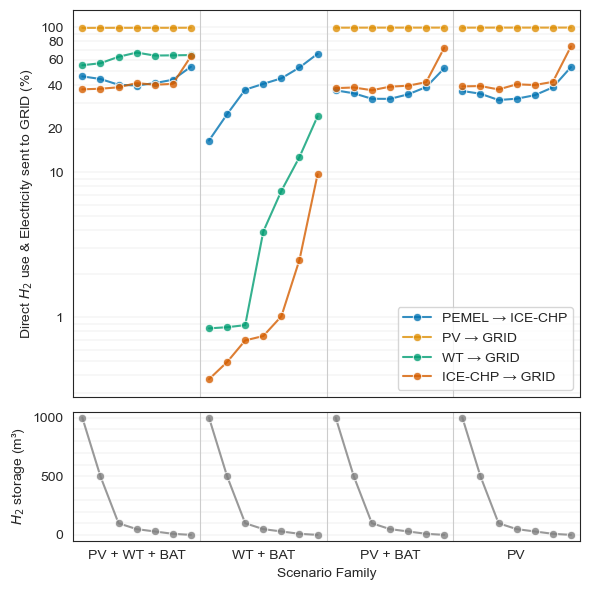

In [22]:
# Set the overall style to white (not darkgrid)
sns.set_style("white")

################## PREPARE ELECTRICITY OVERPRODUCTION DATA ##################

# all_elec_overprod is assumed to have a "Scenario" column and the overproduction columns.
# Extract scenario number from the Scenario column
all_elec_overprod = joblib.load("pickles/all_elec_overprod.pkl")
all_elec_overprod["Scenario Number"] = all_elec_overprod["Scenario"].str.extract(r'(\d+)').astype(int)

# Assign families based on scenario numbers
conditions = [
    all_elec_overprod["Scenario Number"] <= 7,
    (all_elec_overprod["Scenario Number"] >= 8) & (all_elec_overprod["Scenario Number"] <= 14),
    (all_elec_overprod["Scenario Number"] >= 15) & (all_elec_overprod["Scenario Number"] <= 21),
    all_elec_overprod["Scenario Number"] >= 22
]
choices = ["PV + WT + BAT", "WT + BAT", "PV + BAT", "PV"]
all_elec_overprod["Family"] = np.select(conditions, choices, default="")

# Reshape the dataframe into long format for plotting (for overproduction series)
df_melted = all_elec_overprod.melt(
    id_vars=["Scenario Number", "Family"],
    value_vars=["PV overproduction (%)", "WT overproduction (%)", "CHP overproduction (%)"],
    var_name="Source",
    value_name="Overproduction"
)

# Rename sources for the legend
df_melted["Source"] = df_melted["Source"].replace({
    "PV overproduction (%)": "PV → GRID",
    "WT overproduction (%)": "WT → GRID",
    "CHP overproduction (%)": "ICE-CHP → GRID"
})

################## PREPARE H2 DIRECT USE DATA ##################

# all_h2synthesis is assumed to have a "Scenario" column plus "Direct H2 use (%)" (and "Storage (m3)" later)
# Extract scenario number and assign families in the same way
all_h2synthesis = joblib.load("pickles/all_h2synthesis.pkl")
all_h2synthesis["Scenario Number"] = all_h2synthesis["Scenario"].str.extract(r'(\d+)').astype(int)
all_h2synthesis["Family"] = np.select(
    [
        all_h2synthesis["Scenario Number"] <= 7,
        (all_h2synthesis["Scenario Number"] >= 8) & (all_h2synthesis["Scenario Number"] <= 14),
        (all_h2synthesis["Scenario Number"] >= 15) & (all_h2synthesis["Scenario Number"] <= 21),
        all_h2synthesis["Scenario Number"] >= 22
    ],
    choices,
    default=""
)

# Build a new dataframe for Direct H2 Use; rename its column to "Overproduction" for consistency,
# and add a column "Source" with value "H2"
h2use_df = all_h2synthesis[["Scenario Number", "Family", "Direct H2 use (%)"]].copy()
h2use_df = h2use_df.rename(columns={"Direct H2 use (%)": "Overproduction"})
h2use_df["Source"] = "PEMEL → ICE-CHP"

# Append h2use_df to the overproduction data
df_melted = pd.concat([df_melted, h2use_df], ignore_index=True)

################## FILTER OUT INVALID SOURCES (EXCEPT ICE-CHP AND H2? ALWAYS INCLUDED) ##################

valid_sources = {
    "PV + WT + BAT": ["PV → GRID", "WT → GRID", "ICE-CHP → GRID", "PEMEL → ICE-CHP"],
    "WT + BAT": ["WT → GRID", "ICE-CHP → GRID", "PEMEL → ICE-CHP"],
    "PV + BAT": ["PV → GRID", "ICE-CHP → GRID", "PEMEL → ICE-CHP"],
    "PV": ["PV → GRID", "ICE-CHP → GRID", "PEMEL → ICE-CHP"]
}

df_melted = df_melted[df_melted.apply(lambda row: row["Source"] in valid_sources[row["Family"]], axis=1)]

################## PREPARE H2 STORAGE DATA (BOTTOM PANEL) ##################

# Build h2s_df from all_h2synthesis using the "Storage (m3)" column.
h2s_df = all_h2synthesis[["Scenario Number", "Family", "Storage (m3)"]].copy()
h2s_df = h2s_df.rename(columns={"Storage (m3)": "H2S"})

################## PLOT ###################

fig, (ax_top, ax_bottom) = plt.subplots(2, 1, sharex=True, figsize=(6, 6),
                                        gridspec_kw={'height_ratios': [3, 1]})

# Use the colorblind palette for plotting
palette = sns.color_palette("colorblind")
# Define desired order for the top panel legend, with H2 first
desired_order = ["PEMEL → ICE-CHP", "PV → GRID", "WT → GRID", "ICE-CHP → GRID"]
sources = [s for s in desired_order if s in df_melted["Source"].unique()]

################## ELECTRICITY OVERPRODUCTION AND DIRECT H2 USE TRENDS (TOP PANEL) ##################

for i, source in enumerate(sources):
    source_data = df_melted[df_melted["Source"] == source].copy()
    source_data.sort_values("Scenario Number", inplace=True)

    # Initialize legend label flag once per source
    label_assigned = False

    # Group by Family so that a new segment starts at each family boundary.
    for family, fam_data in source_data.groupby("Family"):
        fam_data = fam_data.copy()
        fam_data["seg"] = (fam_data["Overproduction"].isna() !=
                           fam_data["Overproduction"].isna().shift()).cumsum()
        for seg, group in fam_data.groupby("seg"):
            if group["Overproduction"].isna().all():
                continue
            lab = source if not label_assigned else None
            label_assigned = True
            sns.lineplot(
                data=group,
                x="Scenario Number",
                y="Overproduction",
                color=palette[i],
                marker="o",
                ax=ax_top,
                label=lab,
                alpha=0.8
            )

# Set the top axis to logarithmic scale
ax_top.set_yscale("log")
ax_top.set_ylabel("Direct $H_{2}$ use & Electricity sent to GRID (%)")
ax_top.grid(True, which="both", axis="y", linestyle="-", linewidth=0.2)

# Format y-axis: plain numbers (not scientific) and enable minor ticks
ax_top.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:g}'.format(y)))
ax_top.yaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=np.arange(1, 10)*0.1))
ax_top.minorticks_on()

# Set manual y-ticks for the overproduction axis
ticks = [1, 10, 20, 40, 60, 80, 100]
ax_top.set_yticks(ticks)
ax_top.set_yticklabels(ticks)

################## H2 STORAGE PROGRESSION (BOTTOM PANEL) ##################

for family, group in h2s_df.groupby("Family"):
    sns.lineplot(
        data=group,
        x="Scenario Number",
        y="H2S",
        color="grey",
        marker="o",
        ax=ax_bottom,
        legend=False,
        alpha=0.8
    )
ax_bottom.set_ylabel("$H_{2}$ storage (m³)")
ax_bottom.grid(True, which="both", axis="y", linestyle="-", linewidth=0.2)
ax_bottom.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:g}'.format(y)))
ax_bottom.minorticks_on()

################## ADD VERTICAL BORDERS BETWEEN SCENARIO FAMILIES ##################

# Use grid properties to match grid lines
grid_color = plt.rcParams["grid.color"]
grid_linestyle = plt.rcParams["grid.linestyle"]
grid_linewidth = plt.rcParams["grid.linewidth"]
family_boundaries = [7.5, 14.5, 21.5]  # boundaries between (7-8), (14-15), and (21-22)
for boundary in family_boundaries:
    ax_top.axvline(x=boundary, color=grid_color, linestyle=grid_linestyle, linewidth=grid_linewidth)
    ax_bottom.axvline(x=boundary, color=grid_color, linestyle=grid_linestyle, linewidth=grid_linewidth)

################## ADJUST X-AXIS LIMITS FOR TIGHTER BORDERS ##################

ax_top.set_xlim(0.5, 28.5)
ax_bottom.set_xlim(0.5, 28.5)

# Shared X Axis Adjustments
family_midpoints = [np.mean([1, 7]), np.mean([8, 14]), np.mean([15, 21]), np.mean([22, 28])]
family_labels = ["PV + WT + BAT", "WT + BAT", "PV + BAT", "PV"]
ax_bottom.set_xticks(family_midpoints)
ax_bottom.set_xticklabels(family_labels)
ax_bottom.set_xlabel("Scenario Family")

################## DISPLAY AND SAVE ##################

print("Electricity Overproduction, Direct H2 Use & H2 Storage by Scenario")
plt.tight_layout()
plt.savefig('H2DirectU_ElecOverP.png', dpi=300, bbox_inches="tight")
plt.show()

<div style="border: 2px solid #FFA500; padding: 10px; border-radius: 5px; background-color: #FFFACD; color: black; text-align: center;">
  <h2 style="margin: 0;">Combining all Electricity / H<sub>2</sub> / Heat flows in Sankey diagrams</h2>
</div>

**Display interactive Sankey diagrams :**
- Vizualisation of all Electricity, Heat, and H<sub>2</sub> flows calculations
- Possibility to adjust Opacity and Font size as prefered
- Several display modes:
  - Original: the flows are displayed as calculated
  - Log: conversion of the values on a logarithmic scale
  - Threshold: suppress flows and nodes under a certain value. 
  - Threshold and scaled: apply the threshold transformation and scales flows per type (electricity, heat, H<sub>2</sub>)

*Explainer*: 
- The "Threshold" display mode is needed as some variables of the OpenModelica model are sometimes set to 1 instead of 0 for mathematical reasons. For example, WT always appears in the "Original" Sankey diagram despite WT supposed to be absent in Scenarios 15-28. Same goes for BAT in Scenarios 22-28.
- The "Threshold and scaled" display mode is needed to highlight the relative size of flows inside a given flow category (electricity, heat, H<sub>2</sub>)

In [23]:
########## LOAD RESULTS DATA AND DEFINE MAPPINGS ##########

# Load the necessary results data
all_elec_results = joblib.load("pickles/all_elec_results.pkl")
all_h2_results = joblib.load("pickles/all_h2_results.pkl")
all_heat_results = joblib.load("pickles/all_heat_results.pkl")

# Node Name Mapping
elec_mapping = {
    "Pchp": "ICE-CHP", "Pwind": "WT", "Ppv": "PV", "Pload": "LOAD", "Php": "HP",
    "Ppump": "P", "Pbat": "BAT", "Pgrid": "GRID", "Ppemel": "PEMEL", "Pcom": "H2C/S"
}

heat_mapping = {
    "Qchp": "ICE-CHP", "Qload": "LOAD", "Qhp": "HP", "Qtes": "TES"
}

h2_mapping = {
    "H2load": "ICE-CHP", "H2cs": "H2C/S", "H2pemel": "PEMEL"
}

# Colorblind-Friendly Node Color Mapping
node_color_map = {
    "PV": "#009E73", "WT": "#009E73", "GRID": "#009E73", "BAT": "#009E73",
    "ICE-CHP": "#4D4D4D", "PEMEL": "#005F99", "H2C/S": "#005F99",
    "LOAD": "#E69F00", "HP": "#882255", "TES": "#882255"
}

# Helper function to convert HEX to RGBA
def convert_to_rgba(hex_color, opacity):
    hex_color = hex_color.lstrip("#")
    r, g, b = tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))
    return f"rgba({r},{g},{b},{opacity})"

# Load Data with mapping
def process_data(df, mapping, flow_type):
    flows = [col for col in df.columns if "->" in col]
    structured_data = []
    for _, row in df.iterrows():
        scenario = row["Scenario"]
        for flow in flows:
            source, target = [s.strip() for s in flow.split("->")]
            source = mapping.get(source, source)
            target = mapping.get(target, target)
            value = row[flow]
            structured_data.append({
                "Scenario": scenario, "Source": source, "Target": target,
                "Value": value, "FlowType": flow_type
            })
    return pd.DataFrame(structured_data)

elec_df = process_data(all_elec_results, elec_mapping, "elec")
h2_df = process_data(all_h2_results, h2_mapping, "h2")
heat_df = process_data(all_heat_results, heat_mapping, "heat")
df = pd.concat([elec_df, h2_df, heat_df])
if df.empty:
    raise ValueError("The combined DataFrame is empty. Check if the input data is loaded correctly.")

########## DEFINE NODES AND DATA TRANSFORMATIONS ##########

# Get Node List
all_nodes = sorted(list(set(df["Source"].tolist() + df["Target"].tolist())))
node_indices = {node: i for i, node in enumerate(all_nodes)}

# Define Transformation Functions
transformation_types = ['original', 'log', 'threshold', 'threshold & scaled']

def get_transformed_data(scenario, transformation, threshold_value=5):
    df_scenario = df[df["Scenario"] == scenario].copy()
    # Always store original values for hover display
    df_scenario["OriginalValue"] = df_scenario["Value"]

    # Apply the selected transformation
    if transformation == 'threshold':
        # Filter flows using the original values only, but do NOT change the node set.
        df_filtered = df_scenario[df_scenario["Value"] >= threshold_value].copy()
        return {
            "nodes": all_nodes,
            "source": [node_indices[src] for src in df_filtered["Source"]],
            "target": [node_indices[tgt] for tgt in df_filtered["Target"]],
            "value": df_filtered["Value"].tolist(),
            "flow_types": df_filtered["FlowType"].tolist(),
            "original_value": df_filtered["OriginalValue"].tolist()
        }

    elif transformation == 'threshold & scaled':
        max_elec = df_scenario[df_scenario["FlowType"] == "elec"]["Value"].max()
        max_heat = df_scenario[df_scenario["FlowType"] == "heat"]["Value"].max()
        max_h2 = df_scenario[df_scenario["FlowType"] == "h2"]["Value"].max()

        heat_scale_factor = (2 / 3) * max_elec / max_heat if max_heat > 0 else 1
        h2_scale_factor = (1 / 3) * max_elec / max_h2 if max_h2 > 0 else 1

        df_scenario["TransformedValue"] = df_scenario.apply(
            lambda row: row["Value"] * heat_scale_factor if row["FlowType"] == "heat" else
                        row["Value"] * h2_scale_factor if row["FlowType"] == "h2" else
                        row["Value"],
            axis=1
        )

        # Apply threshold after scaling
        df_filtered = df_scenario[df_scenario["TransformedValue"] >= threshold_value].copy()
        nodes_filtered = sorted(set(df_filtered["Source"].tolist() + df_filtered["Target"].tolist()))
        node_indices_filtered = {node: i for i, node in enumerate(nodes_filtered)}
        return {
            "nodes": nodes_filtered,
            "source": [node_indices_filtered[src] for src in df_filtered["Source"]],
            "target": [node_indices_filtered[tgt] for tgt in df_filtered["Target"]],
            "value": df_filtered["TransformedValue"].tolist(),
            "original_value": df_filtered["OriginalValue"].tolist(),
            "flow_types": df_filtered["FlowType"].tolist()
        }

    elif transformation == 'log':
        df_scenario["TransformedValue"] = np.log1p(df_scenario["Value"])

    elif transformation == 'original':
        df_scenario["TransformedValue"] = df_scenario["Value"]

    else:
        # Normalize if other future transformations are added
        max_val = df_scenario["Value"].max()
        df_scenario["TransformedValue"] = df_scenario["Value"] / max_val

    # For 'threshold only' and other default transformations, return all nodes
    return {
        "nodes": all_nodes,
        "source": [node_indices[src] for src in df_scenario["Source"]],
        "target": [node_indices[tgt] for tgt in df_scenario["Target"]],
        "value": df_scenario["TransformedValue"].tolist(),
        "original_value": df_scenario["OriginalValue"].tolist(),
        "flow_types": df_scenario["FlowType"].tolist()
    }

########## GENERATE SANKEY DIAGRAM ##########

def create_sankey_figure(scenario, transformation, threshold_value=5, opacity=0.5, label_size=30):
    data_trans = get_transformed_data(scenario, transformation, threshold_value)
    # For transformed cases, use filtered nodes; otherwise, all nodes.
    nodes_used = data_trans["nodes"] if transformation == 'threshold & scaled' else all_nodes
    current_node_indices = {node: i for i, node in enumerate(nodes_used)}

    # Colors for nodes and links
    node_colors = [convert_to_rgba(node_color_map.get(node, "#BBBBBB"), opacity) for node in nodes_used]
    link_colors = [
        convert_to_rgba("#009E73", opacity) if flow_type == "elec" else
        convert_to_rgba("#882255", opacity) if flow_type == "heat" else
        convert_to_rgba("#005F99", opacity)
        for flow_type in data_trans["flow_types"]
    ]

    # Build hover text using the original values.
    # Note: The source and target indices in data_trans refer to positions in the nodes list.
    hover_text = []
    # Use the node names from nodes_used if filtered, else from all_nodes.
    for src_idx, tgt_idx, orig in zip(data_trans["source"], data_trans["target"], data_trans["original_value"]):
        # When using full nodes, src_idx and tgt_idx are valid indices into all_nodes.
        # When using filtered nodes, they are valid into nodes_used.
        src_name = nodes_used[src_idx]
        tgt_name = nodes_used[tgt_idx]
        hover_text.append(f"{src_name} → {tgt_name}: {orig:.2f}")

    sankey = go.Sankey(
        node=dict(pad=15, thickness=20, line=dict(color="black", width=0.5),
                  label=nodes_used, color=node_colors),
        link=dict(source=data_trans["source"], target=data_trans["target"],
                  value=data_trans["value"], color=link_colors,
                  customdata=hover_text, hovertemplate="%{customdata}<extra></extra>")
    )
    fig = go.Figure(sankey)
    fig.update_layout(font_size=label_size)
    return fig

########## BUILD DASH APP ##########

app = dash.Dash(__name__)
app.layout = html.Div([
    # Title
    html.H3("Electricity, Heat & Hydrogen Sankey Diagram",
            style={"text-align": "center", "margin-bottom": "0px"}),
    # Display data and graph options
    html.Div([
        html.Label("Select Scenario:"),
        dcc.Dropdown(id="scenario-dropdown",
                     options=[{"label": s, "value": s} for s in df["Scenario"].unique()],
                     value=df["Scenario"].unique()[0],
                     style={"margin-bottom": "20px"}), # Reduce spacing
        html.Label("Select Transformation:"),
        dcc.Dropdown(id="transformation-dropdown",
                     options=[{"label": t.capitalize(), "value": t} for t in transformation_types],
                     value="original",
                     style={"margin-bottom": "20px"}), # Reduce spacing
        html.Label("Adjust Flow Opacity:"),
        dcc.Slider(id='slider', min=0, max=1, value=0.5, step=0.1,
                   marks={i/10: str(i/10) for i in range(0, 11)},
                   tooltip={"placement": "bottom", "always_visible": True}),
        html.Label("Adjust Node Label Size:"),
        dcc.Slider(id='label-size-slider', min=20, max=60, value=15, step=1,
                   marks={i: str(i) for i in range(20, 61)}),
        html.Br(),
        dcc.Graph(id="sankey-graph", style={"width": "100%", "height": "500px"}),

        # Legend, set to be closer to the graph
        html.Div([
            html.Div(style={"width": "20px", "height": "20px", "background-color": "rgba(0, 158, 115, 0.5)", "margin-right": "10px"}),
            html.Span("Electricity flow (kWh)", style={"font-size": "14px", "margin-right": "10px"}),
            html.Div(style={"width": "20px", "height": "20px", "background-color": "rgba(136, 34, 85, 0.5)", "margin-right": "10px"}),
            html.Span("Heat flow (MJ)", style={"font-size": "14px", "margin-right": "10px"}),
            html.Div(style={"width": "20px", "height": "20px", "background-color": "rgba(0, 95, 153, 0.5)", "margin-right": "10px"}),
            html.Span("H\u2082 flow (kg)", style={"font-size": "14px", "margin-right": "10px"}) # H₂ with subscript
        ], style={"display": "flex", "justify-content": "center", "margin-top": "10px"}),
        html.Br(),

        # Buttons for saving sankey diagram
        html.Button("Save as 600 DPI PNG", id="save-png-btn", n_clicks=0, style={"margin-right": "10px"}),
        html.Button("Save as PDF", id="save-pdf-btn", n_clicks=0),
        html.Div(id="save-message", style={"margin-top": "10px", "font-weight": "bold", "color": "#444"})
    ], style={"width": "60%", "margin": "0 auto"})
])

# Wire the update of everything
@app.callback(
    Output("sankey-graph", "figure"),
    Input("scenario-dropdown", "value"),
    Input("transformation-dropdown", "value"),
    Input("slider", "value"),
    Input("label-size-slider", "value")
)

def update_sankey(selected_scenario, selected_transformation, opacity, label_size):
    return create_sankey_figure(selected_scenario, selected_transformation, opacity=opacity, label_size=label_size)

@app.callback(
    Output("save-message", "children"),
    Input("save-png-btn", "n_clicks"),
    Input("save-pdf-btn", "n_clicks"),
    State("scenario-dropdown", "value"),
    State("transformation-dropdown", "value"),
    State("slider", "value"),
    State("label-size-slider", "value"),
    prevent_initial_call=True
)

# Saving figure options
def save_figure(png_clicks, pdf_clicks, scenario, transformation, opacity, label_size):
    ctx = dash.callback_context
    if not ctx.triggered:
        raise dash.exceptions.PreventUpdate

    button_id = ctx.triggered[0]["prop_id"].split(".")[0]
    fig = create_sankey_figure(scenario, transformation, opacity=opacity, label_size=label_size)
    filename_base = f"sankey_{scenario}_{transformation}".replace(" ", "_").lower()

    width = 1920
    height = int(width * 9 / 17)
    scale = 3.125  # This gives 600 DPI for print quality

    try:
        if button_id == "save-png-btn":
            fig.write_image(f"{filename_base}.png", width=width, height=height, scale=scale)
            return f"PNG saved as {filename_base}.png"
        elif button_id == "save-pdf-btn":
            fig.write_image(f"{filename_base}.pdf", width=width, height=height)
            return f"PDF saved as {filename_base}.pdf"
    except Exception as e:
        return f"Error saving file: {str(e)}"

# Run
if __name__ == '__main__':
    app.run_server(debug=True, port=8050)
